now working /home/ken/src/github.com/endaaman/bt



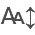

In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
from sklearn.decomposition import PCA
import ipynbname
from endaaman.ml import fix_global_seed
from itables import init_notebook_mode
# from ydata_profiling import ProfileReport

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)

DPI = 300

sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 
plt.rcParams['figure.dpi'] = DPI

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

init_notebook_mode(all_interactive=True)
# print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

LIMIT = 500

## Table2: Cross Validation

In [2]:
mm = [
    'Accuracy(Patch)', 
    'Accuracy', 
    'Recall', 
    'Precision', 
    'F1 score', 
    'G Recall', 
    'A Recall', 
    'O Recall', 
    'M Recall', 
    'L Recall', 
]

skip_when_coarse = ['A Recall', 'O Recall']

def dump_to_table(target, coarse=False, result_limit=100):
    r = None
    error_type = 'ci'
    grains = 'coarse' if coarse else 'fine'
    P = f'out/figs/table2_{grains}_{target}.xlsx'
    with pd.ExcelWriter(P) as w:
        for limit in [10, 25, 100, 500]:
            df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)
            data = []
            labels = df['label'].unique()
            for l in labels:
                vvv = df[df['label'] == l]
                ss = {}
                for m in mm:
                    if coarse and m in skip_when_coarse:
                        continue
                    vv = vvv[m].values
                    mean = np.mean(vv)
                    if len(vv) > 0 and vv.std() > 0:
                        if error_type == 'ci':
                            ci = stats.t.interval(confidence=0.95, df=len(vv)-1, loc=mean, scale=stats.sem(vv))
                            error = (ci[1] - ci[0])/2
                        else:
                            error = stats.sem(vv)
                    else:
                        error = 0.0
                    s = '{:.3f} ± {:.3f}'.format(mean, error)
                    ss[m] = s
                data.append(ss)
            df2 = pd.DataFrame(data, index=labels)
            df2.to_excel(w, sheet_name=f'{limit}')
            w.sheets[f'{limit}'].set_column('A:A', 30)
            w.sheets[f'{limit}'].set_column('B:Z', 12)
            if limit == result_limit:
                r = df2
    print(f'wrote {P}')
    return r 

## Table2: Local cross-validation

In [3]:
dump_to_table('cv', False, 10)

wrote out/figs/table2_fine_cv.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.894 ± 0.027  0.912 ± 0.034   
UNI(FT)                            0.901 ± 0.030  0.914 ± 0.034   
UNI(LP)                            0.887 ± 0.027  0.917 ± 0.041   
CTransPath(FT)                     0.854 ± 0.030  0.884 ± 0.044   
CTransPath(LP)                     0.838 ± 0.027  0.853 ± 0.057   
VIT-L$\mathrm{_{IN}}$(FT)          0.816 ± 0.044  0.846 ± 0.056   
VIT-L$\mathrm{_{IN}}$(LP)          0.767 ± 0.037  0.760 ± 0.075   
VIT-L(RI)                          0.642 ± 0.044  0.553 ± 0.077   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.792 ± 0.042  0.831 ± 0.062   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.481 ± 0.032  0.482 ± 0.053   

                                         Recall      Precision       F1 score  \
Prov-GigaPath(LP)                 0.826 ± 0.066  0.838 ± 0.083  0.811 ± 0.075   
UNI(FT)                           0.828 ± 0.071  0.810 ± 0.128  0.807 ± 0.101   
UNI(LP)                           0.840 ± 0.081  0.855 ± 0.104  0.827 ± 0.089   
CTransPath(FT)                    0.787 ± 0.079  0.841 ± 0.089  0.787 ± 0.079   
CTransPath(LP)                    0.767 ± 0.082  0.816 ± 0.105  0.750 ± 0.103   
VIT-L$\mathrm{_{IN}}$(FT)         0.749 ± 0.093  0.817 ± 0.041  0.754 ± 0.076   
VIT-L$\mathrm{_{IN}}$(LP)         0.591 ± 0.093  0.740 ± 0.140  0.604 ± 0.100   
VIT-L(RI)                         0.371 ± 0.074  0.445 ± 0.153  0.358 ± 0.091   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.742 ± 0.071  0.800 ± 0.014  0.736 ± 0.067   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.354 ± 0.069  0.224 ± 0.049  0.253 ± 0.060   

                                       G Recall       A Recall       O Recall  \
Prov-GigaPath(LP)                 0.938 ± 0.080  0.300 ± 0.304  0.920 ± 0.136   
UNI(FT)                           0.909 ± 0.044  0.260 ± 0.347  0.920 ± 0.136   
UNI(LP)                           0.892 ± 0.160  0.413 ± 0.407  0.880 ± 0.136   
CTransPath(FT)                    0.879 ± 0.108  0.300 ± 0.176  0.820 ± 0.254   
CTransPath(LP)                    0.776 ± 0.232  0.307 ± 0.278  0.920 ± 0.136   
VIT-L$\mathrm{_{IN}}$(FT)         0.686 ± 0.207  0.507 ± 0.296  0.620 ± 0.333   
VIT-L$\mathrm{_{IN}}$(LP)         0.457 ± 0.380  0.233 ± 0.275  0.200 ± 0.248   
VIT-L(RI)                         0.154 ± 0.324  0.320 ± 0.283  0.040 ± 0.111   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.657 ± 0.324  0.540 ± 0.272  0.660 ± 0.299   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.000 ± 0.000  0.000 ± 0.000  0.280 ± 0.333   

                                       M Recall       L Recall  
Prov-GigaPath(LP)                 0.988 ± 0.035  0.807 ± 0.183  
UNI(FT)                           0.976 ± 0.041  0.904 ± 0.119  
UNI(LP)                           0.988 ± 0.035  0.865 ± 0.130  
CTransPath(FT)                    0.938 ± 0.078  0.787 ± 0.101  
CTransPath(LP)                    0.926 ± 0.085  0.673 ± 0.157  
VIT-L$\mathrm{_{IN}}$(FT)         0.938 ± 0.055  0.745 ± 0.224  
VIT-L$\mathrm{_{IN}}$(LP)         0.926 ± 0.035  0.729 ± 0.218  
VIT-L(RI)                         0.545 ± 0.125  0.169 ± 0.217  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.888 ± 0.037  0.709 ± 0.246  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.000 ± 0.000  0.920 ± 0.136

In [4]:
dump_to_table('cv', True, LIMIT)

wrote out/figs/table2_coarse_cv.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.972 ± 0.014  0.992 ± 0.014   
UNI(FT)                            0.974 ± 0.012  0.990 ± 0.013   
UNI(LP)                            0.972 ± 0.015  0.990 ± 0.013   
CTransPath(FT)                     0.962 ± 0.014  0.990 ± 0.017   
CTransPath(LP)                     0.948 ± 0.013  0.985 ± 0.013   
VIT-L$\mathrm{_{IN}}$(FT)          0.954 ± 0.017  0.985 ± 0.013   
VIT-L$\mathrm{_{IN}}$(LP)          0.909 ± 0.018  0.952 ± 0.021   
VIT-L(RI)                          0.911 ± 0.017  0.947 ± 0.026   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.956 ± 0.011  0.990 ± 0.007   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.516 ± 0.060  0.543 ± 0.084   

                                         Recall      Precision       F1 score  \
Prov-GigaPath(LP)                 0.992 ± 0.014  0.991 ± 0.017  0.991 ± 0.016   
UNI(FT)                           0.987 ± 0.016  0.987 ± 0.017  0.986 ± 0.016   
UNI(LP)                           0.987 ± 0.016  0.989 ± 0.016  0.988 ± 0.016   
CTransPath(FT)                    0.989 ± 0.018  0.985 ± 0.025  0.987 ± 0.023   
CTransPath(LP)                    0.980 ± 0.017  0.987 ± 0.012  0.983 ± 0.015   
VIT-L$\mathrm{_{IN}}$(FT)         0.982 ± 0.015  0.982 ± 0.017  0.981 ± 0.015   
VIT-L$\mathrm{_{IN}}$(LP)         0.944 ± 0.022  0.938 ± 0.028  0.939 ± 0.025   
VIT-L(RI)                         0.926 ± 0.039  0.949 ± 0.033  0.935 ± 0.036   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.987 ± 0.011  0.989 ± 0.010  0.988 ± 0.009   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.499 ± 0.087  0.438 ± 0.034  0.439 ± 0.084   

                                       G Recall       M Recall       L Recall  
Prov-GigaPath(LP)                 0.982 ± 0.030  0.988 ± 0.035  1.000 ± 0.000  
UNI(FT)                           0.991 ± 0.024  0.976 ± 0.041  0.980 ± 0.056  
UNI(LP)                           0.982 ± 0.030  0.988 ± 0.035  0.980 ± 0.056  
CTransPath(FT)                    0.982 ± 0.030  0.976 ± 0.041  1.000 ± 0.000  
CTransPath(LP)                    0.974 ± 0.047  0.988 ± 0.035  0.960 ± 0.068  
VIT-L$\mathrm{_{IN}}$(FT)         0.974 ± 0.049  0.975 ± 0.069  0.980 ± 0.056  
VIT-L$\mathrm{_{IN}}$(LP)         0.905 ± 0.097  0.951 ± 0.065  0.922 ± 0.103  
VIT-L(RI)                         0.957 ± 0.002  0.902 ± 0.084  0.844 ± 0.109  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.991 ± 0.024  0.975 ± 0.043  0.980 ± 0.056  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.784 ± 0.188  0.000 ± 0.000  0.569 ± 0.356

## Table2: EBRAINS

In [5]:
dump_to_table('ebrains', False, LIMIT)

wrote out/figs/table2_fine_ebrains.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.703 ± 0.015  0.731 ± 0.021   
UNI(FT)                            0.680 ± 0.030  0.704 ± 0.036   
UNI(LP)                            0.726 ± 0.013  0.760 ± 0.017   
CTransPath(FT)                     0.645 ± 0.026  0.681 ± 0.024   
CTransPath(LP)                     0.653 ± 0.022  0.709 ± 0.026   
VIT-L$\mathrm{_{IN}}$(FT)          0.576 ± 0.041  0.611 ± 0.044   
VIT-L$\mathrm{_{IN}}$(LP)          0.553 ± 0.042  0.622 ± 0.040   
VIT-L(RI)                          0.465 ± 0.043  0.485 ± 0.045   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.562 ± 0.044  0.595 ± 0.041   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.118 ± 0.037  0.301 ± 0.050   

                                         Recall      Precision       F1 score  \
Prov-GigaPath(LP)                 0.760 ± 0.021  0.758 ± 0.023  0.746 ± 0.025   
UNI(FT)                           0.757 ± 0.029  0.734 ± 0.043  0.718 ± 0.042   
UNI(LP)                           0.794 ± 0.016  0.778 ± 0.019  0.779 ± 0.017   
CTransPath(FT)                    0.724 ± 0.016  0.708 ± 0.026  0.702 ± 0.022   
CTransPath(LP)                    0.738 ± 0.023  0.736 ± 0.031  0.724 ± 0.024   
VIT-L$\mathrm{_{IN}}$(FT)         0.667 ± 0.034  0.648 ± 0.057  0.625 ± 0.046   
VIT-L$\mathrm{_{IN}}$(LP)         0.668 ± 0.035  0.653 ± 0.024  0.621 ± 0.046   
VIT-L(RI)                         0.449 ± 0.032  0.454 ± 0.034  0.422 ± 0.043   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.652 ± 0.030  0.632 ± 0.053  0.612 ± 0.048   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.310 ± 0.048  0.569 ± 0.061  0.201 ± 0.051   

                                       G Recall       A Recall       O Recall  \
Prov-GigaPath(LP)                 0.822 ± 0.039  0.677 ± 0.067  0.456 ± 0.134   
UNI(FT)                           0.838 ± 0.034  0.369 ± 0.140  0.725 ± 0.148   
UNI(LP)                           0.824 ± 0.061  0.665 ± 0.080  0.574 ± 0.096   
CTransPath(FT)                    0.806 ± 0.056  0.480 ± 0.061  0.525 ± 0.061   
CTransPath(LP)                    0.798 ± 0.041  0.660 ± 0.082  0.433 ± 0.122   
VIT-L$\mathrm{_{IN}}$(FT)         0.790 ± 0.089  0.292 ± 0.127  0.513 ± 0.099   
VIT-L$\mathrm{_{IN}}$(LP)         0.730 ± 0.115  0.462 ± 0.245  0.407 ± 0.288   
VIT-L(RI)                         0.600 ± 0.118  0.248 ± 0.115  0.336 ± 0.086   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.754 ± 0.066  0.292 ± 0.111  0.480 ± 0.072   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.000 ± 0.000  0.118 ± 0.172  0.948 ± 0.104   

                                       M Recall       L Recall  
Prov-GigaPath(LP)                 0.898 ± 0.022  0.949 ± 0.000  
UNI(FT)                           0.889 ± 0.012  0.963 ± 0.009  
UNI(LP)                           0.953 ± 0.022  0.956 ± 0.019  
CTransPath(FT)                    0.872 ± 0.046  0.939 ± 0.019  
CTransPath(LP)                    0.885 ± 0.014  0.912 ± 0.040  
VIT-L$\mathrm{_{IN}}$(FT)         0.847 ± 0.043  0.895 ± 0.040  
VIT-L$\mathrm{_{IN}}$(LP)         0.868 ± 0.060  0.871 ± 0.035  
VIT-L(RI)                         0.740 ± 0.057  0.769 ± 0.098  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.834 ± 0.043  0.902 ± 0.056  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.000 ± 0.000  0.485 ± 0.203

In [6]:
dump_to_table('ebrains', True, LIMIT)

wrote out/figs/table2_coarse_ebrains.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.892 ± 0.008  0.932 ± 0.005   
UNI(FT)                            0.876 ± 0.037  0.908 ± 0.038   
UNI(LP)                            0.908 ± 0.011  0.941 ± 0.013   
CTransPath(FT)                     0.868 ± 0.022  0.914 ± 0.004   
CTransPath(LP)                     0.858 ± 0.021  0.928 ± 0.013   
VIT-L$\mathrm{_{IN}}$(FT)          0.810 ± 0.041  0.875 ± 0.025   
VIT-L$\mathrm{_{IN}}$(LP)          0.750 ± 0.044  0.834 ± 0.025   
VIT-L(RI)                          0.706 ± 0.060  0.733 ± 0.070   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.806 ± 0.034  0.869 ± 0.030   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.444 ± 0.159  0.733 ± 0.029   

                                         Recall      Precision       F1 score  \
Prov-GigaPath(LP)                 0.927 ± 0.006  0.870 ± 0.011  0.895 ± 0.005   
UNI(FT)                           0.918 ± 0.020  0.842 ± 0.051  0.870 ± 0.043   
UNI(LP)                           0.948 ± 0.006  0.883 ± 0.022  0.912 ± 0.015   
CTransPath(FT)                    0.909 ± 0.016  0.841 ± 0.009  0.870 ± 0.008   
CTransPath(LP)                    0.912 ± 0.012  0.860 ± 0.027  0.883 ± 0.018   
VIT-L$\mathrm{_{IN}}$(FT)         0.872 ± 0.019  0.784 ± 0.040  0.818 ± 0.030   
VIT-L$\mathrm{_{IN}}$(LP)         0.854 ± 0.021  0.742 ± 0.027  0.779 ± 0.025   
VIT-L(RI)                         0.559 ± 0.024  0.512 ± 0.045  0.518 ± 0.048   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.868 ± 0.011  0.781 ± 0.042  0.812 ± 0.033   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.460 ± 0.049  0.741 ± 0.028  0.424 ± 0.025   

                                       G Recall       M Recall       L Recall  
Prov-GigaPath(LP)                 0.934 ± 0.008  0.898 ± 0.022  0.949 ± 0.000  
UNI(FT)                           0.901 ± 0.050  0.889 ± 0.012  0.963 ± 0.009  
UNI(LP)                           0.936 ± 0.020  0.953 ± 0.022  0.956 ± 0.019  
CTransPath(FT)                    0.915 ± 0.007  0.872 ± 0.046  0.939 ± 0.019  
CTransPath(LP)                    0.938 ± 0.020  0.885 ± 0.014  0.912 ± 0.040  
VIT-L$\mathrm{_{IN}}$(FT)         0.875 ± 0.041  0.847 ± 0.043  0.895 ± 0.040  
VIT-L$\mathrm{_{IN}}$(LP)         0.822 ± 0.038  0.868 ± 0.060  0.871 ± 0.035  
VIT-L(RI)                         0.725 ± 0.098  0.740 ± 0.057  0.769 ± 0.098  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.868 ± 0.044  0.834 ± 0.043  0.902 ± 0.056  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.896 ± 0.070  0.000 ± 0.000  0.485 ± 0.203

## fig3: Box - Cross Validation

In [7]:
import random
import colorcet as cc

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'VIT-L$\mathrm{_{IN}}$(FT)',
    r'VIT-L$\mathrm{_{IN}}$(LP)',
    r'VIT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50(RI)',
]
print(len(labels))
# colors = sns.color_palette('pastel20', len(label))
colors = sns.color_palette(cc.glasbey_hv, n_colors=len(labels))
color_map = dict(zip(labels, colors))
display(colors)

11


[(0.18824, 0.63529, 0.85490),
 (0.98823, 0.30980, 0.18824),
 (0.89804, 0.68235, 0.21961),
 (0.42745, 0.56471, 0.30980),
 (0.54510, 0.54510, 0.54510),
 (0.09020, 0.74510, 0.81176),
 (0.58039, 0.40392, 0.74118),
 (0.83922, 0.15294, 0.15686),
 (0.12157, 0.46667, 0.70588),
 (0.89020, 0.46667, 0.76078),
 (0.54902, 0.33726, 0.29412)]

In [8]:
from statsmodels.stats.multitest import multipletests

verbose = False

def paired_box(target:str, 
               coarse:bool, 
               limit:int, 
               key:str, 
               show:bool=False, 
               excludes=['frozen_baseline-cnn'],
               sort=False,
               mean=False,
               log_scale=False,
              ):
    grains = 'coarse' if coarse else 'fine'
    key_map = {
        'pacc': 'Accuracy(Patch)',
        'recall': 'Recall',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }
    key_label = key_map[key]
    
    df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)    
    for e in excludes:
        df = df[~df['cond'].str.startswith(e)]
    labels = list(df['label'].unique())

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key_label].mean().sort_values(ascending=True)
    df[f'average_{key}'] = df['cond'].map(df_mean)
    if sort:
        df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
    else:
        df = df[::-1]
    
    labels_sorted = df['label'].unique()

    # Create figure with GridSpec
    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[3, 1], hspace=0.5, wspace=0.2)

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[1, 1])

    # Box plot
    
    sns.boxplot(x='label', hue='label', y=key_label, data=df, legend=True, palette=[color_map[label] for label in labels_sorted], ax=ax1)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax1.plot(range(n_models), fold_data[key_label], 'k-', alpha=0.3, linewidth=0.5)
    
    # Scatter individual points
    for i, label in enumerate(labels_sorted):
        ax1.scatter([i] * n_folds, df[df['label'] == label][key_label], color='black', s=10, zorder=3)
    
    # Plot mean
    if mean:
        ax1.plot(range(n_models), df_mean, 'firebrick', linewidth=1, zorder=4, alpha=0.4)
        mean_scatter = ax1.scatter(range(n_models), df_mean, color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    ax1.set_title(key_label)
    ax1.set_xticks(range(len(labels_sorted)))
    ax1.set_xticklabels(labels_sorted, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.set_ylabel(key_label)


    # Calculate p-values
    p_values = []
    for i in range(n_models):
        for j in range(i+1, n_models):
            a = df[df['label']==labels_sorted[i]][key_label]
            b = df[df['label']==labels_sorted[j]][key_label]
            t_stat, p_value = stats.ttest_rel(a, b)
            p_values.append(p_value)

    # Benjamini-Hochberg correction
    _, p_values, _, _ = multipletests(p_values, method='fdr_bh')


    # Create significance matrix
    sig_matrix = np.zeros((n_models, n_models))
    k = 0
    for i in range(n_models):
        for j in range(i+1, n_models):
            sig_matrix[j, i] = -np.log10(p_values[k]) if log_scale else p_values[k]
            k += 1

    # Create mask for lower triangle
    mask = np.triu(np.ones_like(sig_matrix, dtype=bool), k=0)

    # Heatmap

    
    V = {'vmin': 0, 'vmax': 3, 'cmap': 'YlOrRd'} if log_scale else {'vmin': 0, 'vmax': 0.1, 'cmap': 'YlOrRd_r'}
    heatmap = sns.heatmap(sig_matrix, mask=mask, annot=True, fmt='.4f', 
                          ax=ax2, cbar_ax=cax, cbar_kws={'label': '-log10(p-value)'}, **V)
    for text in ax2.texts:
        text.set_fontsize(6)


    # Set ax2 properties
    ax2.set_xticklabels(labels_sorted, rotation=45, ha='right')
    ax2.set_yticklabels(labels_sorted, rotation=0)
    ax2.set_title('-log10(p-value)')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Model')

    # handles, labels = ax1.get_legend_handles_labels()
    # handles = handles[:-1][::-1] + [handles[-1]]
    # labels = labels[:-1][::-1] + [labels[-1]]
    # ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    handles, _labels = ax1.get_legend_handles_labels()
    legend_labels = labels
    legend_handles = []
    for i, l in enumerate(labels):
        o = _labels.index(l)
        legend_handles.append(handles[o])
    if mean:
        legend_labels += ['Mean']
        legend_handles += [mean_scatter]
    ax1.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplots_adjust(left=0.30, right=0.70, top=0.95, bottom=0.15)

    print(f'{target} - {grains} - {limit} - {key}')
    fig_path = f'out/figs/box_cv_{grains}_{limit}_{key}.png'
    plt.savefig(fig_path, format='png', dpi=DPI)
    print(f'saved {fig_path}')
    if show:
        plt.show()
    plt.close()

## CV 500 coarse patches/case

## EBRAINS 500 coarse patches/case

cv - fine - 500 - pacc
saved out/figs/box_cv_fine_500_pacc.png


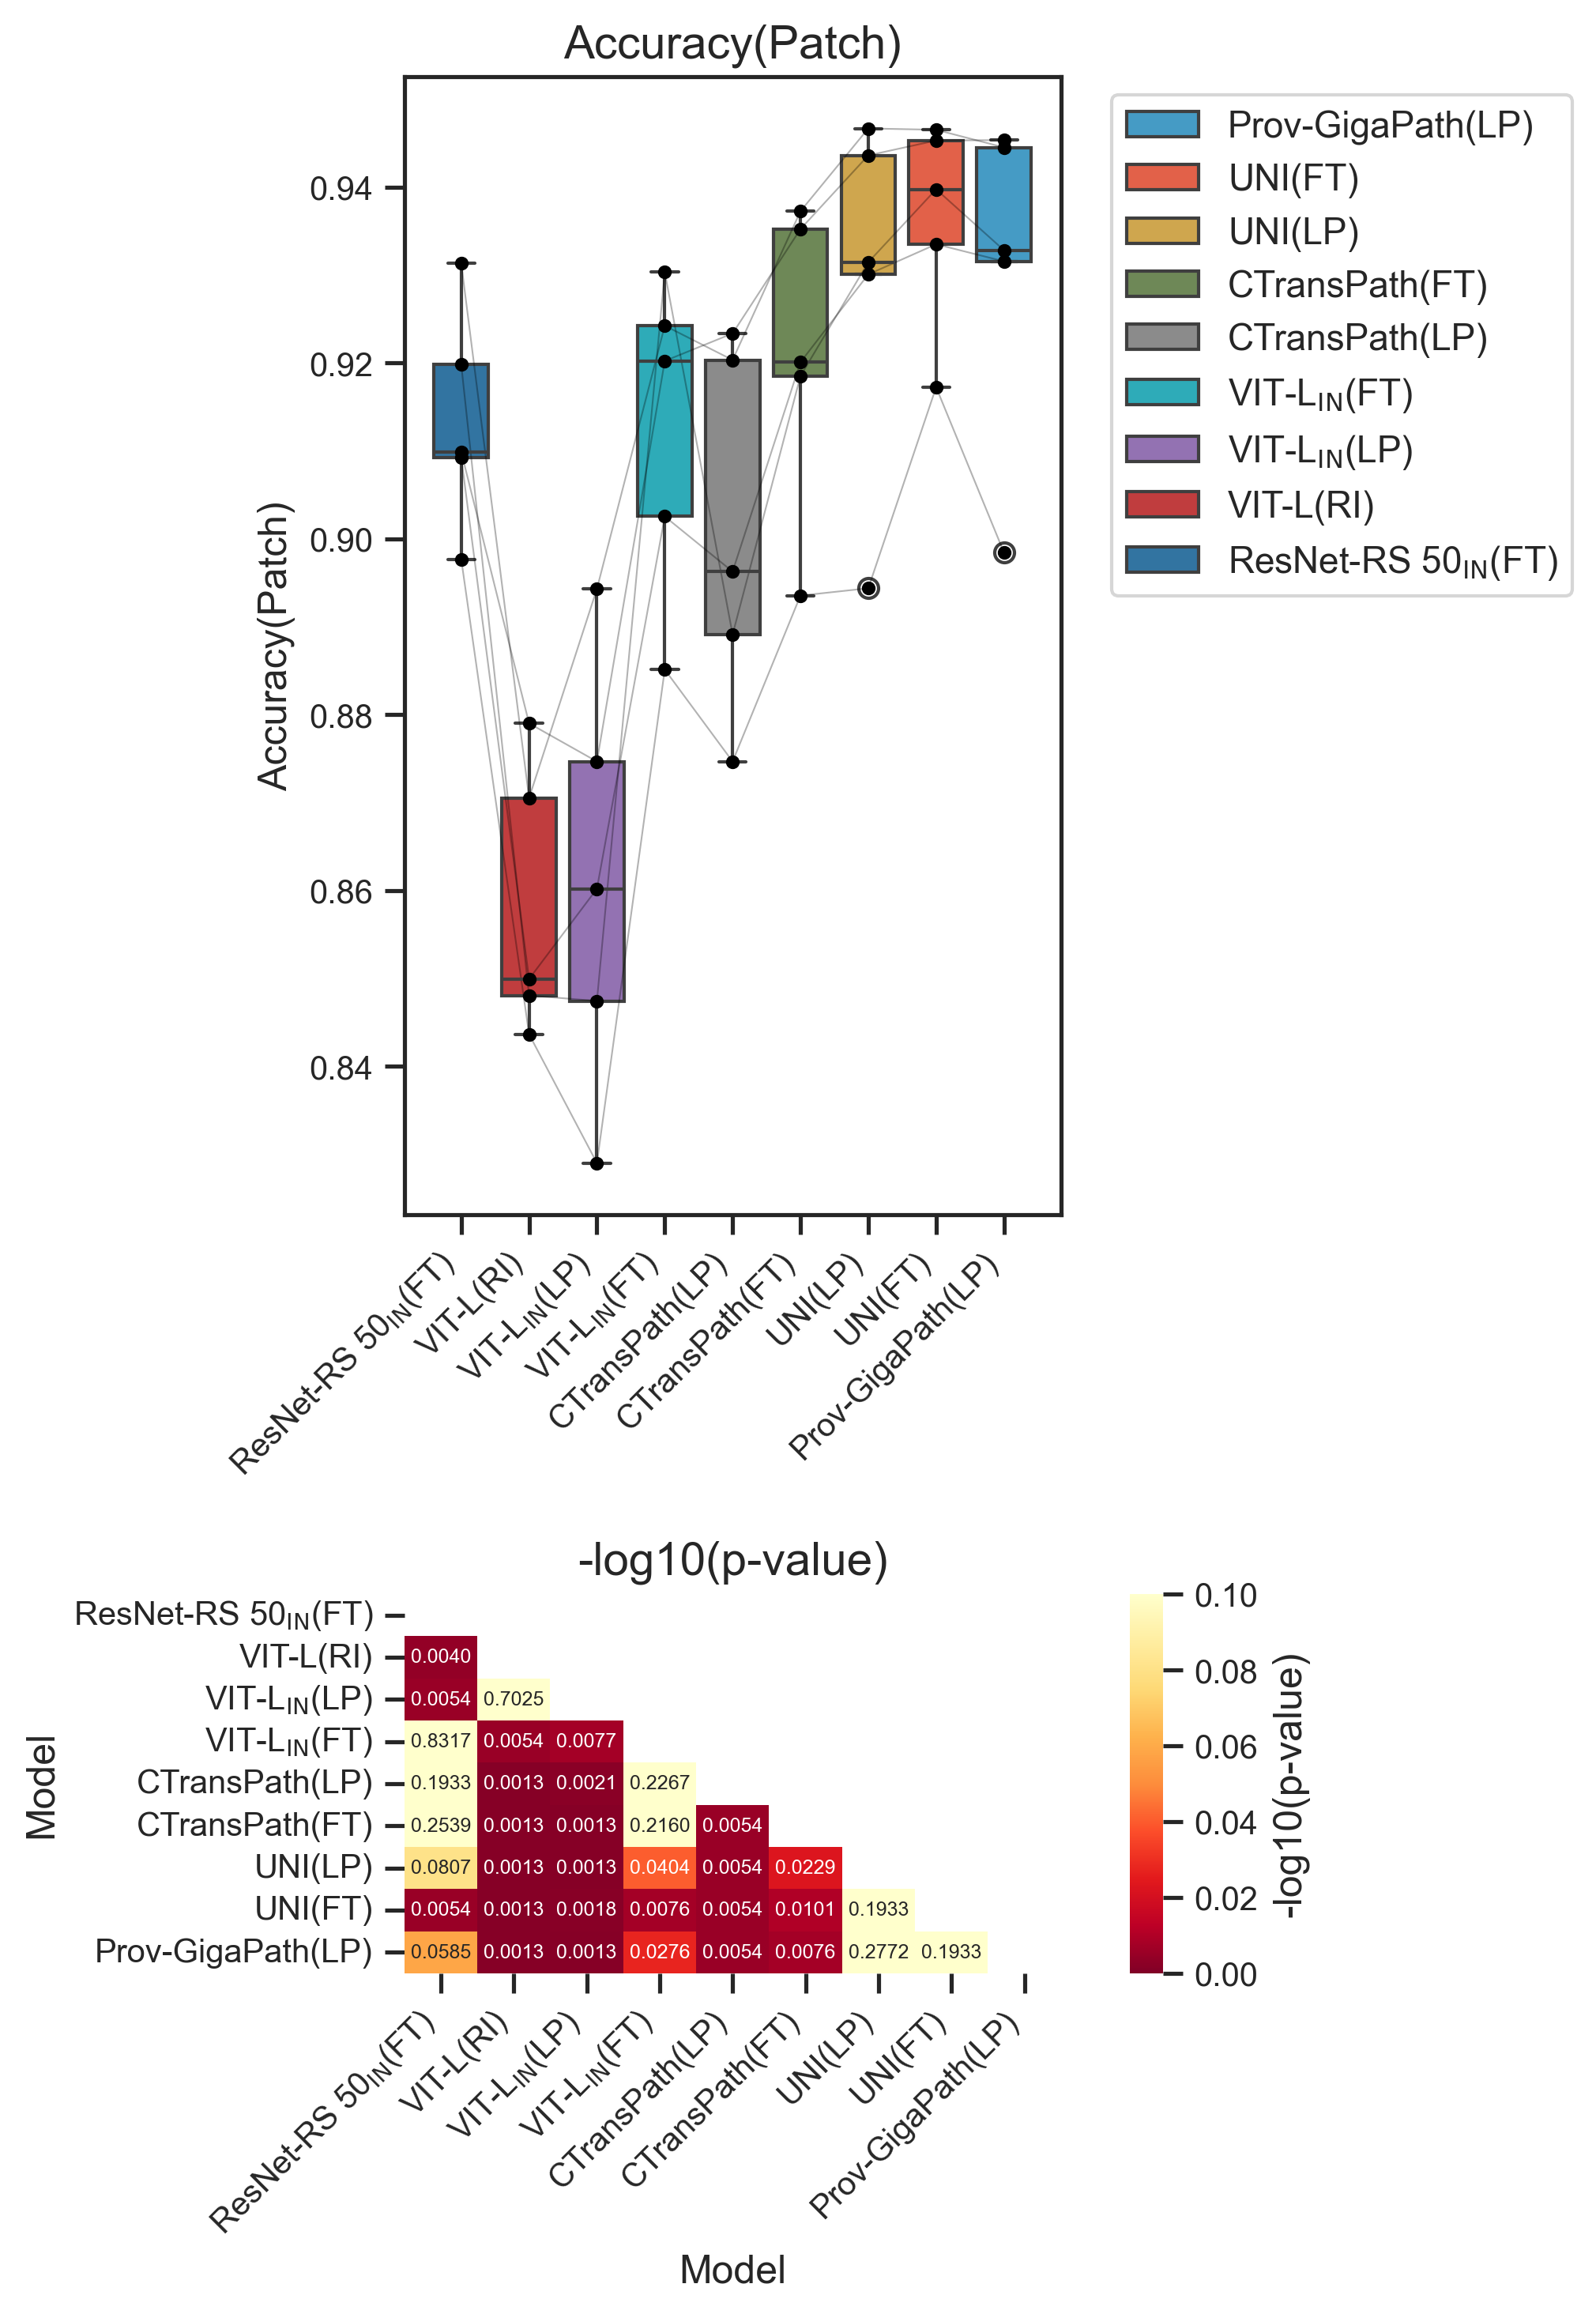

cv - fine - 500 - recall
saved out/figs/box_cv_fine_500_recall.png


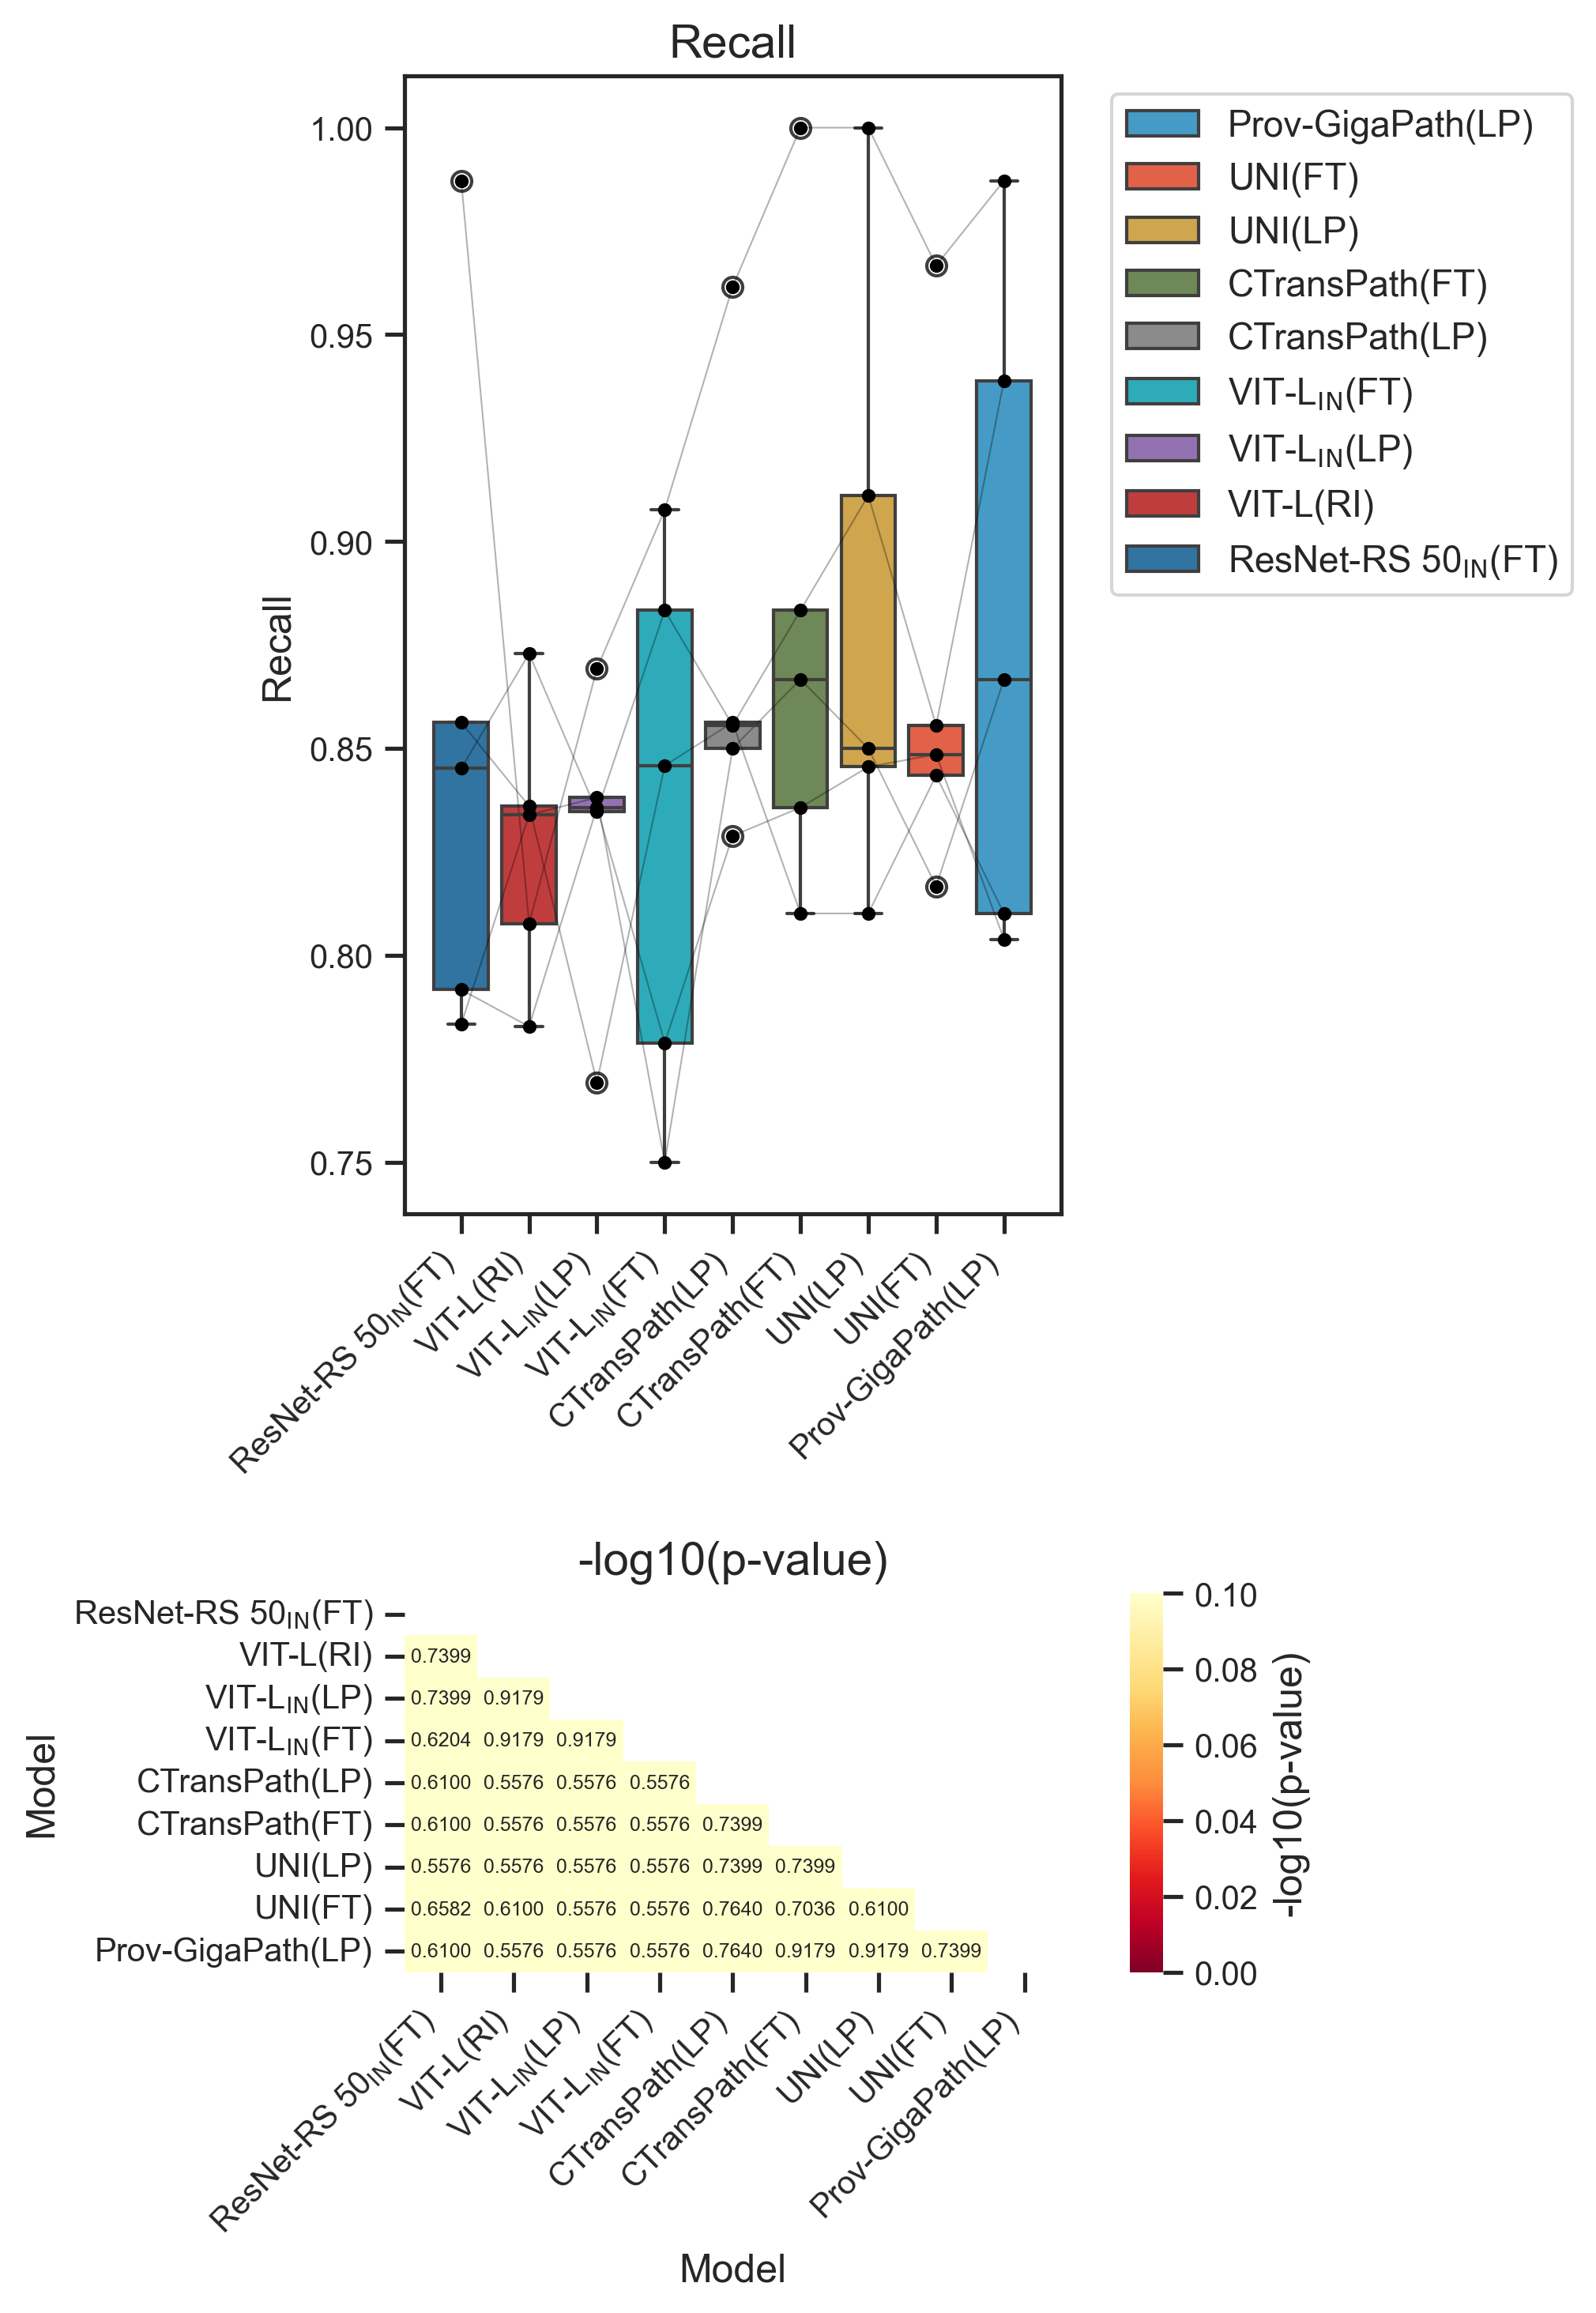

cv - fine - 500 - acc
saved out/figs/box_cv_fine_500_acc.png
cv - fine - 500 - f1
saved out/figs/box_cv_fine_500_f1.png
cv - coarse - 500 - pacc
saved out/figs/box_cv_coarse_500_pacc.png


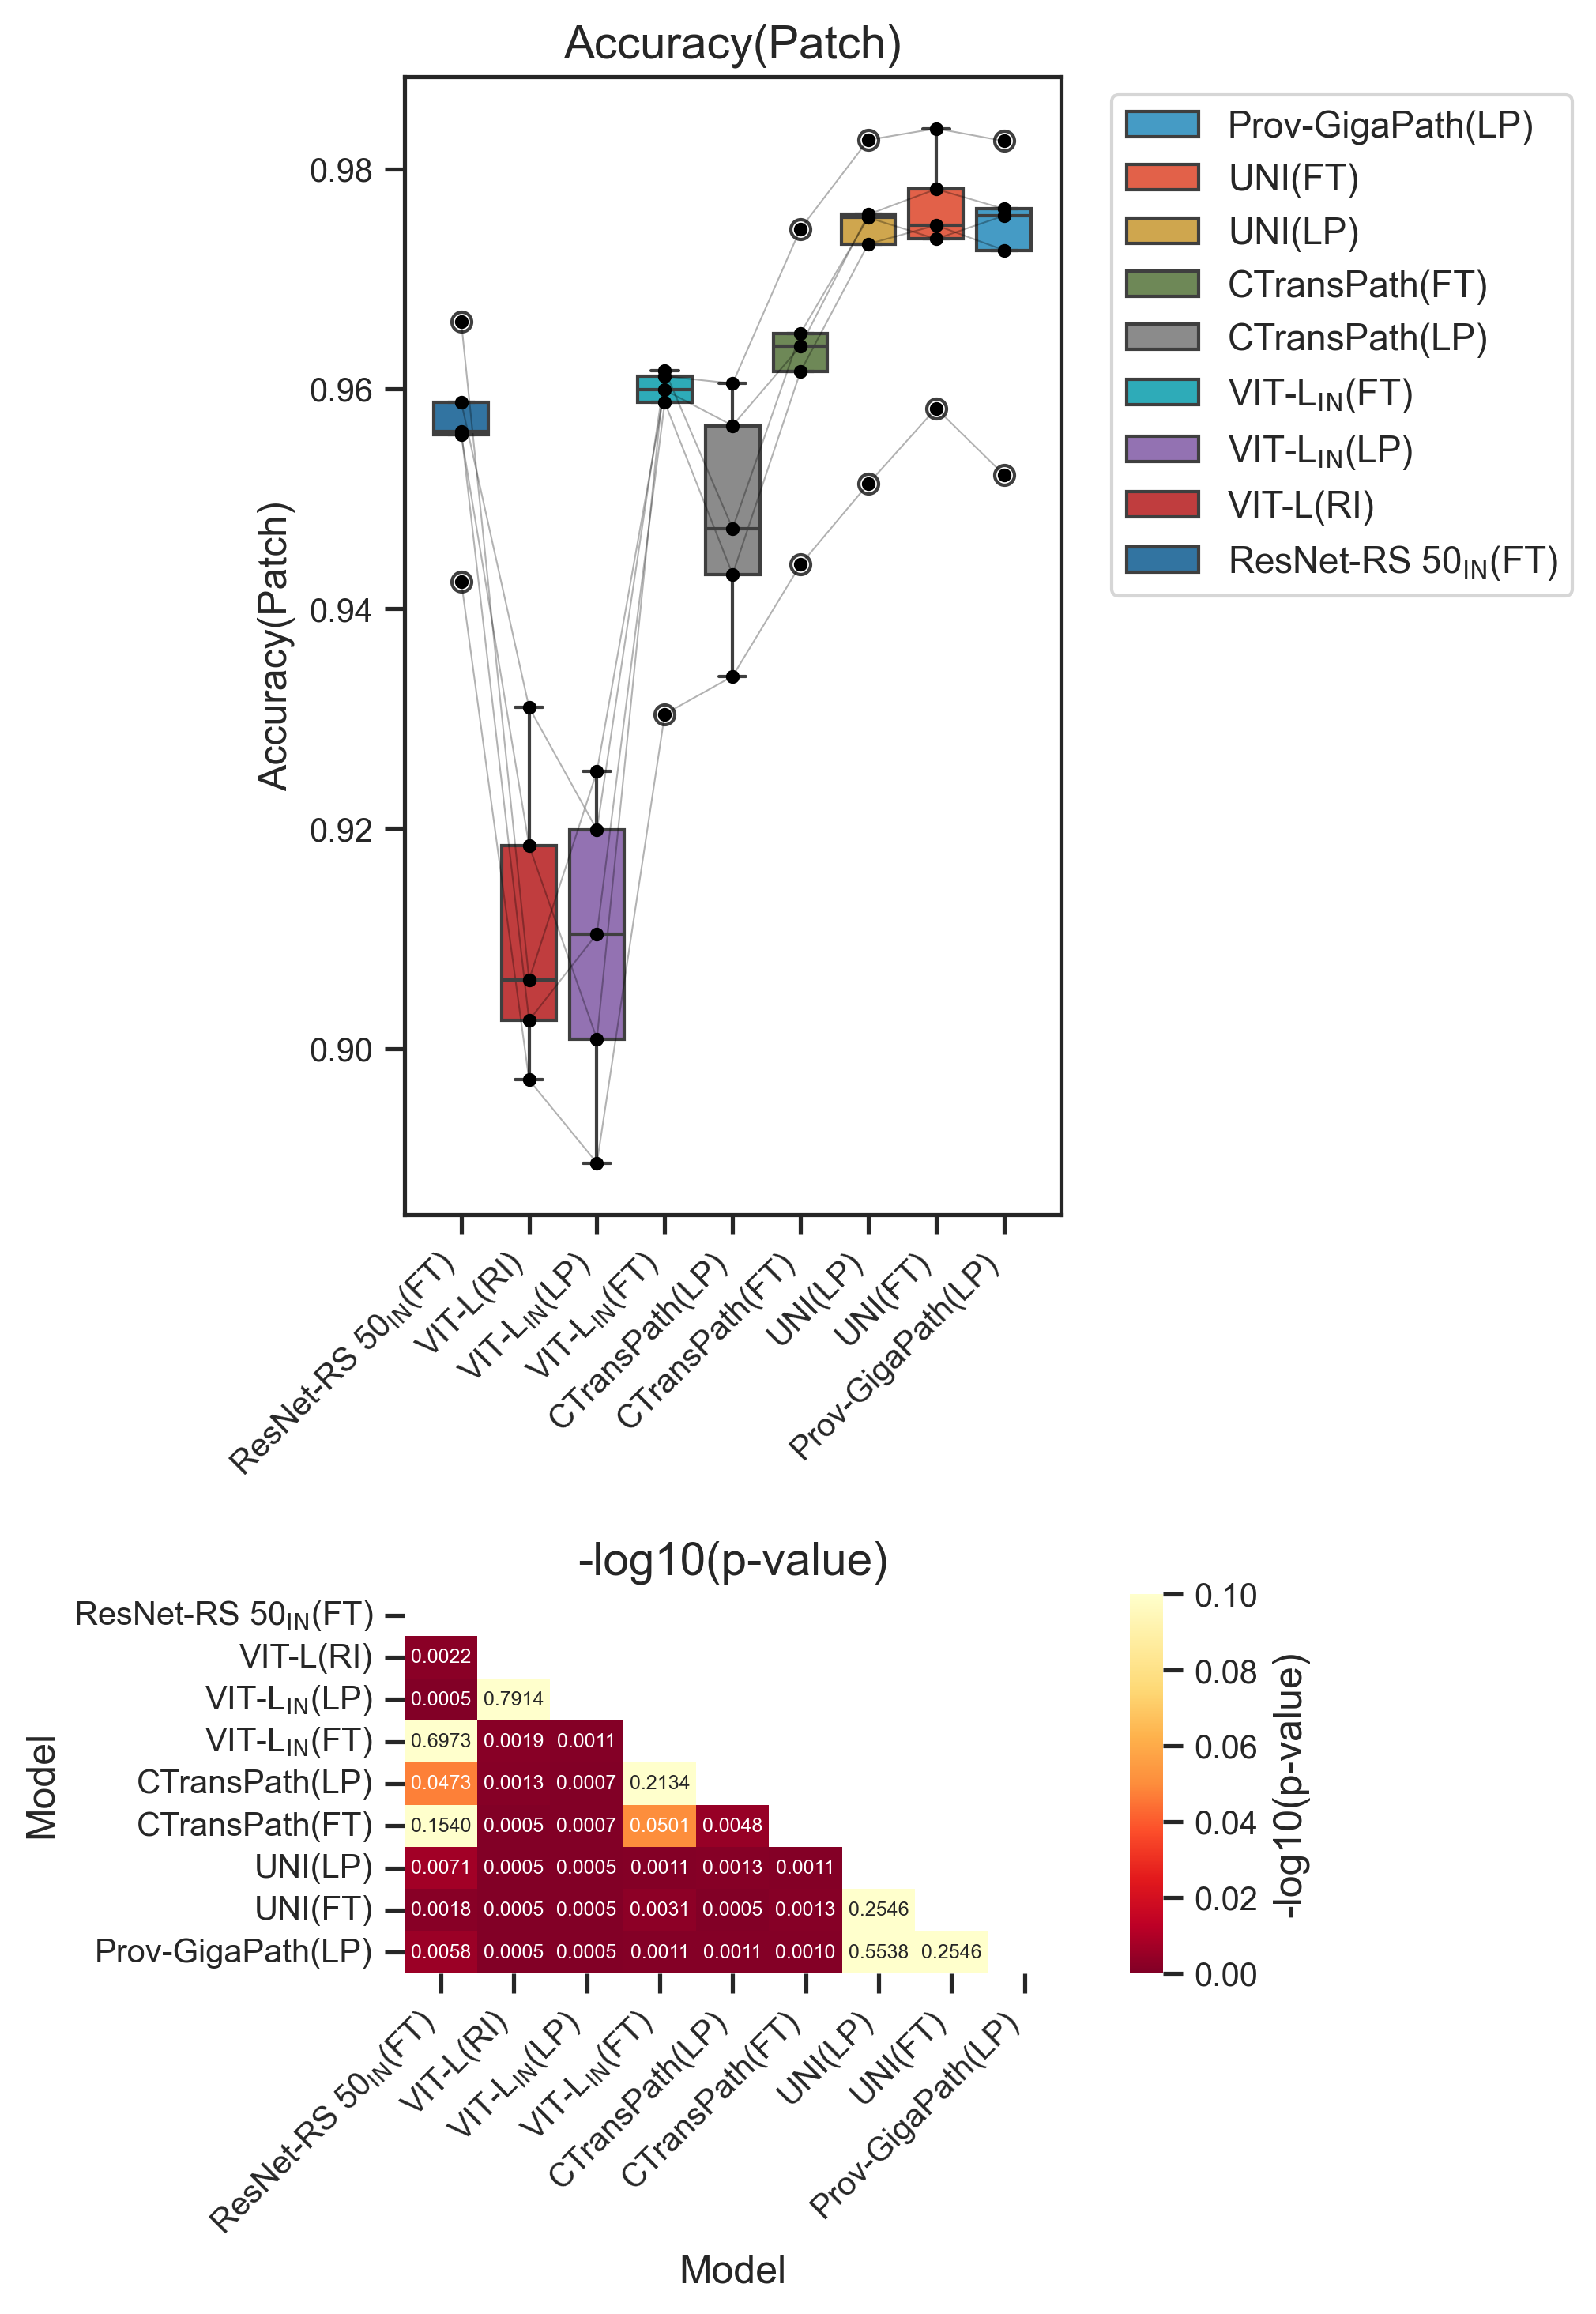

cv - coarse - 500 - recall
saved out/figs/box_cv_coarse_500_recall.png


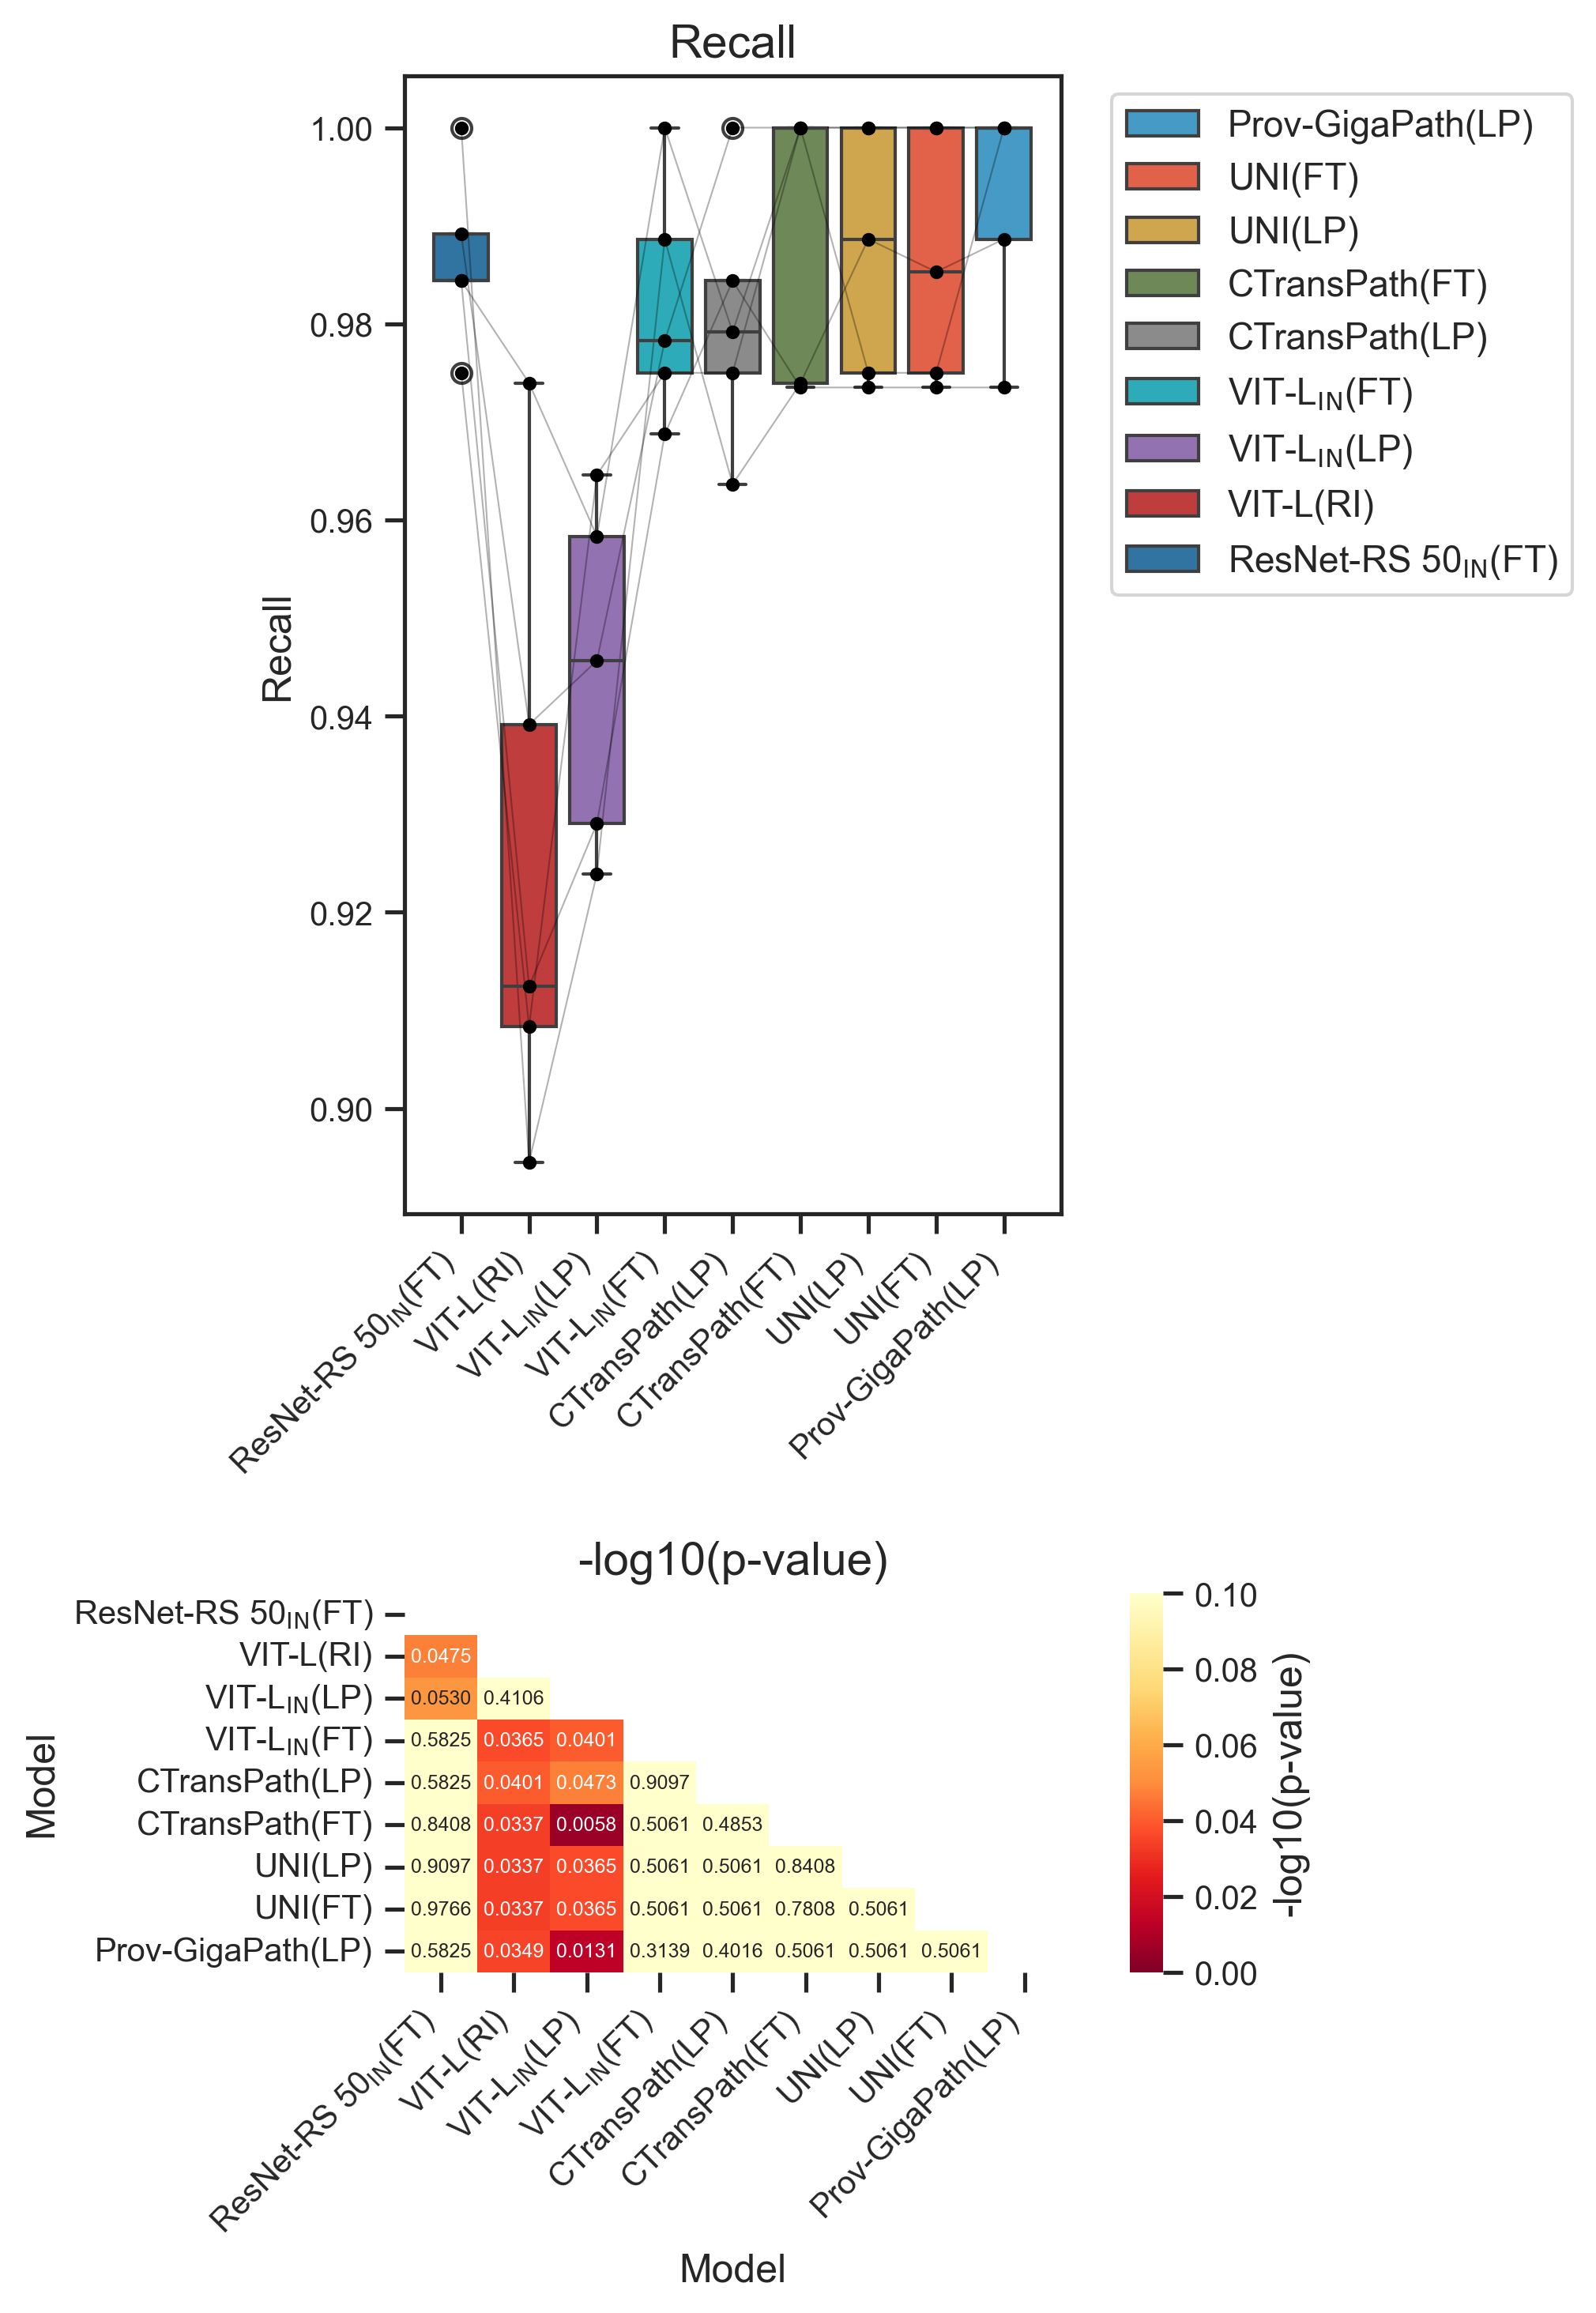

cv - coarse - 500 - acc
saved out/figs/box_cv_coarse_500_acc.png
cv - coarse - 500 - f1
saved out/figs/box_cv_coarse_500_f1.png


In [26]:
paired_box('cv', False, LIMIT, 'pacc', True)
paired_box('cv', False, LIMIT, 'recall', True)
paired_box('cv', False, LIMIT, 'acc')
paired_box('cv', False, LIMIT, 'f1')

paired_box('cv', True, LIMIT, 'pacc', True)
paired_box('cv', True, LIMIT, 'recall', True)
paired_box('cv', True, LIMIT, 'acc')
paired_box('cv', True, LIMIT, 'f1')

### EBRAINS 500 fine patches/case

ebrains - fine - 500 - pacc
saved out/figs/box_cv_fine_500_pacc.png


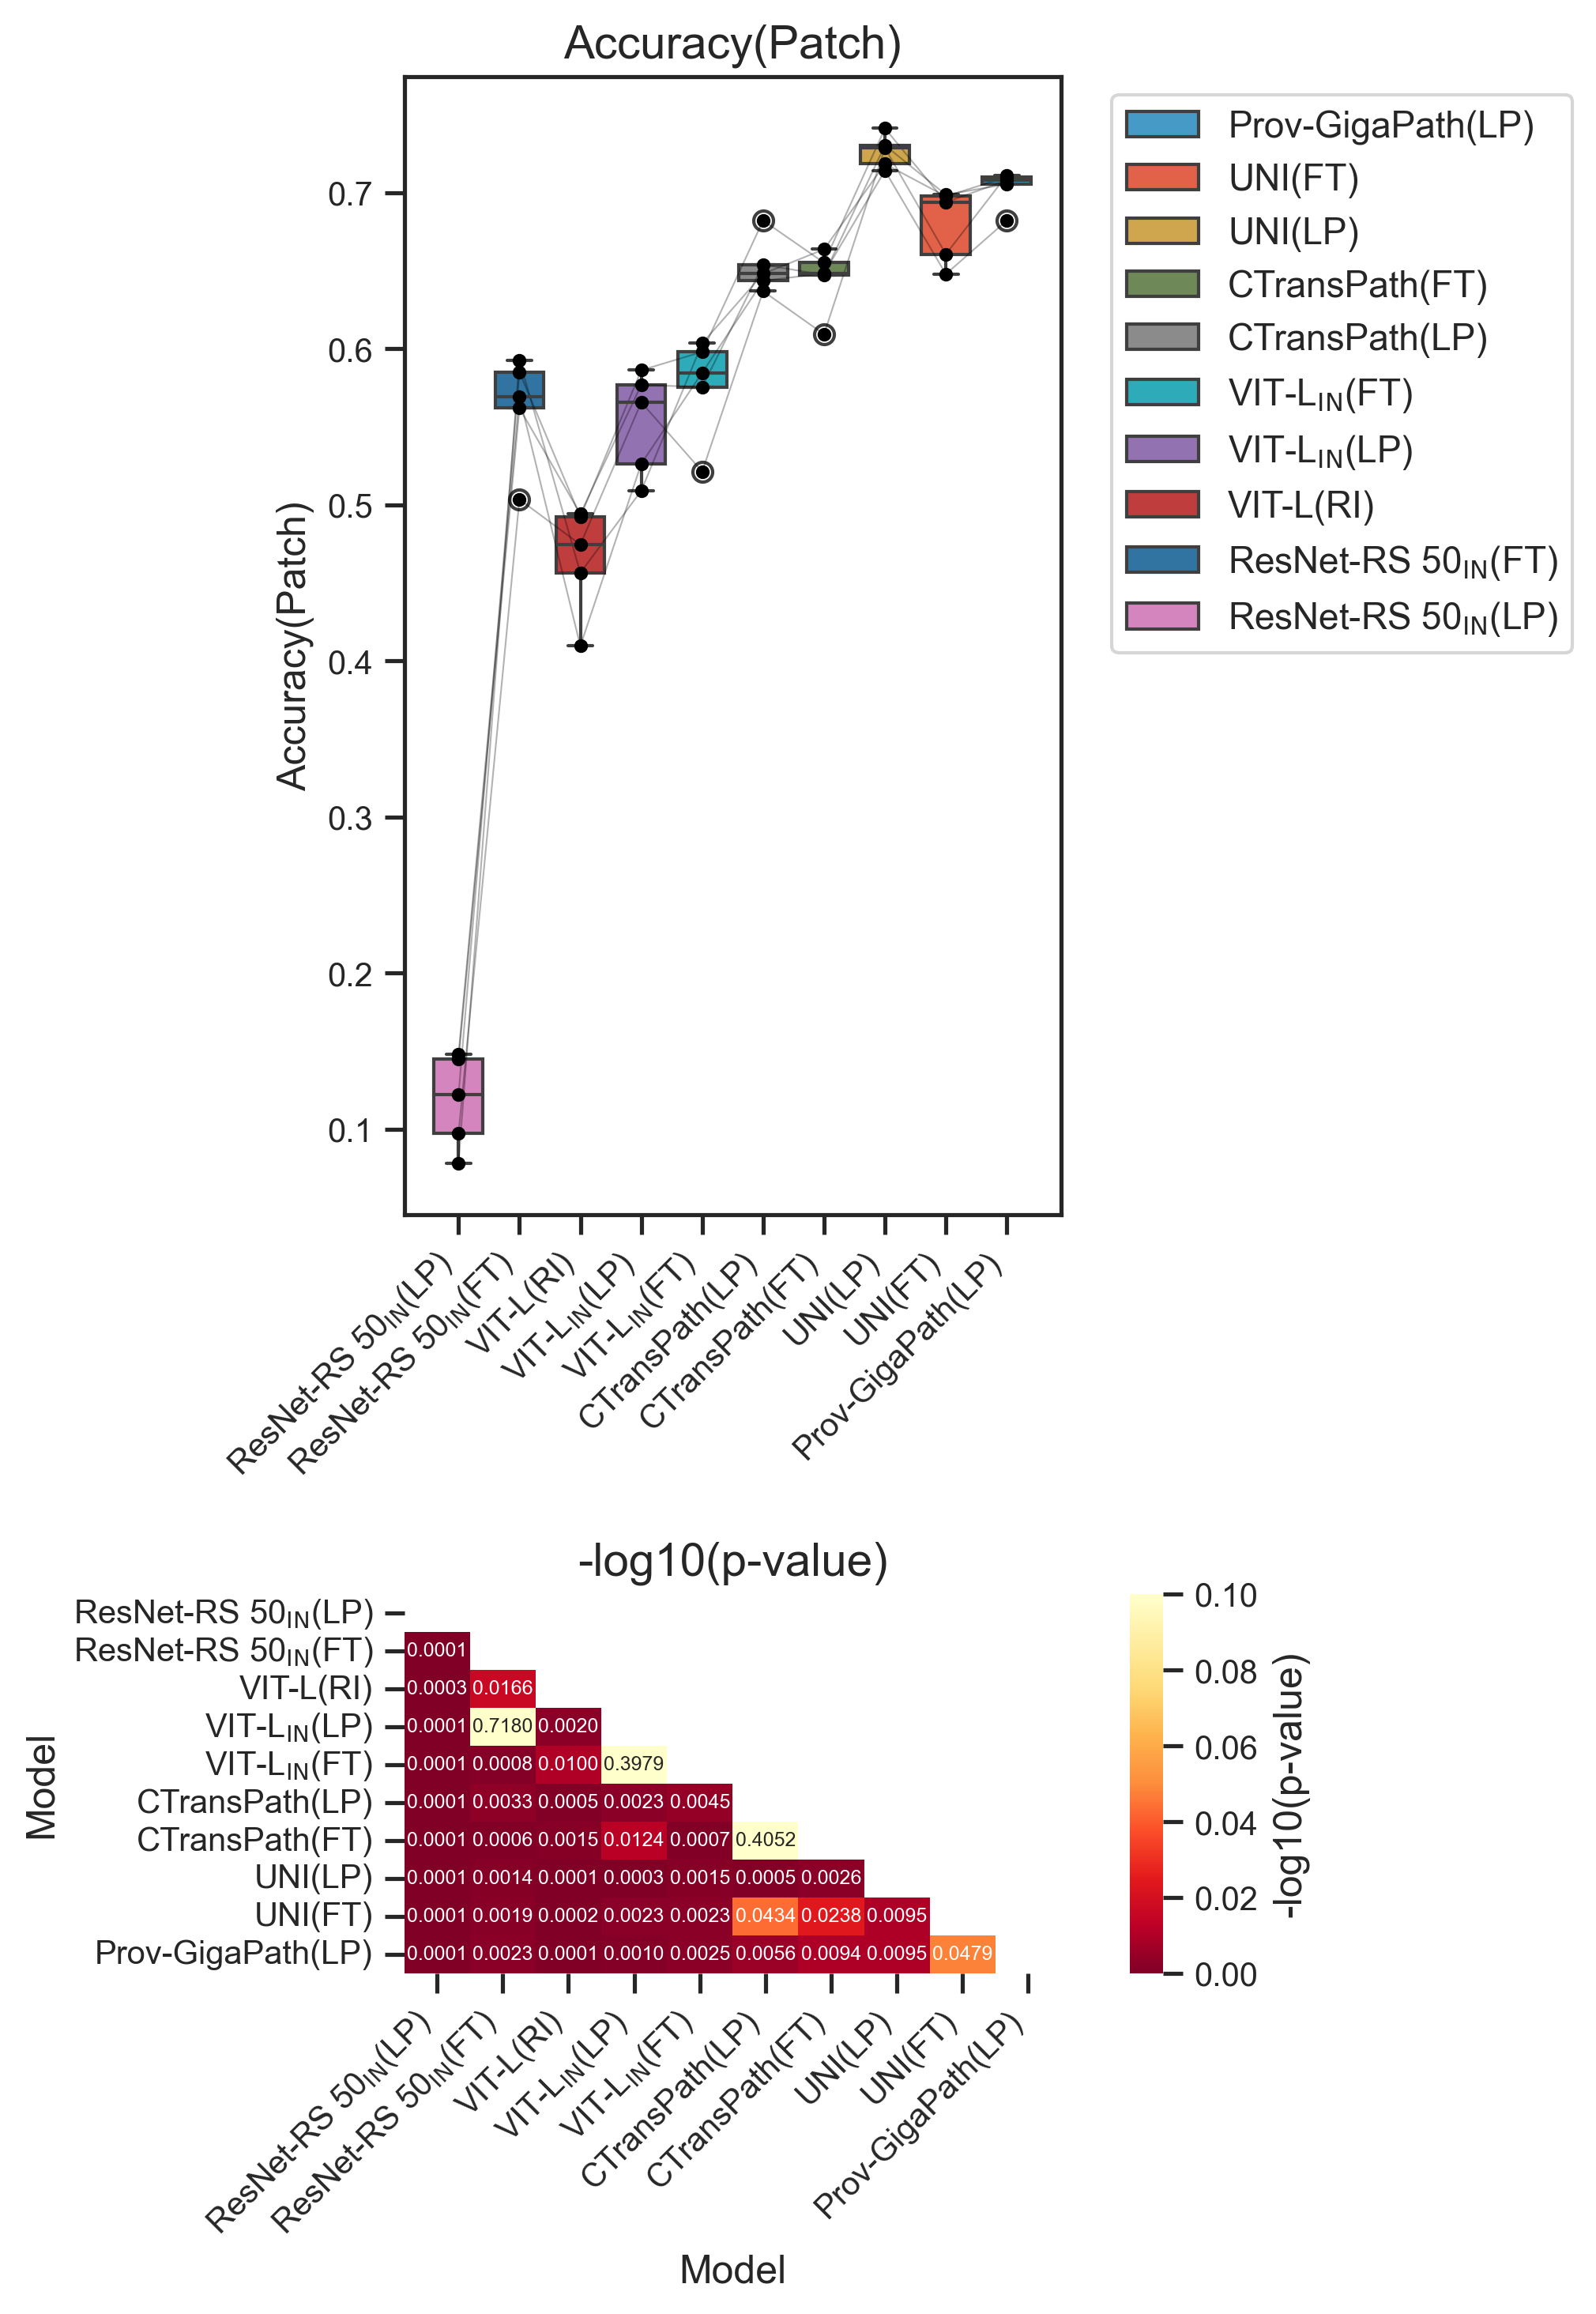

ebrains - fine - 500 - recall
saved out/figs/box_cv_fine_500_recall.png


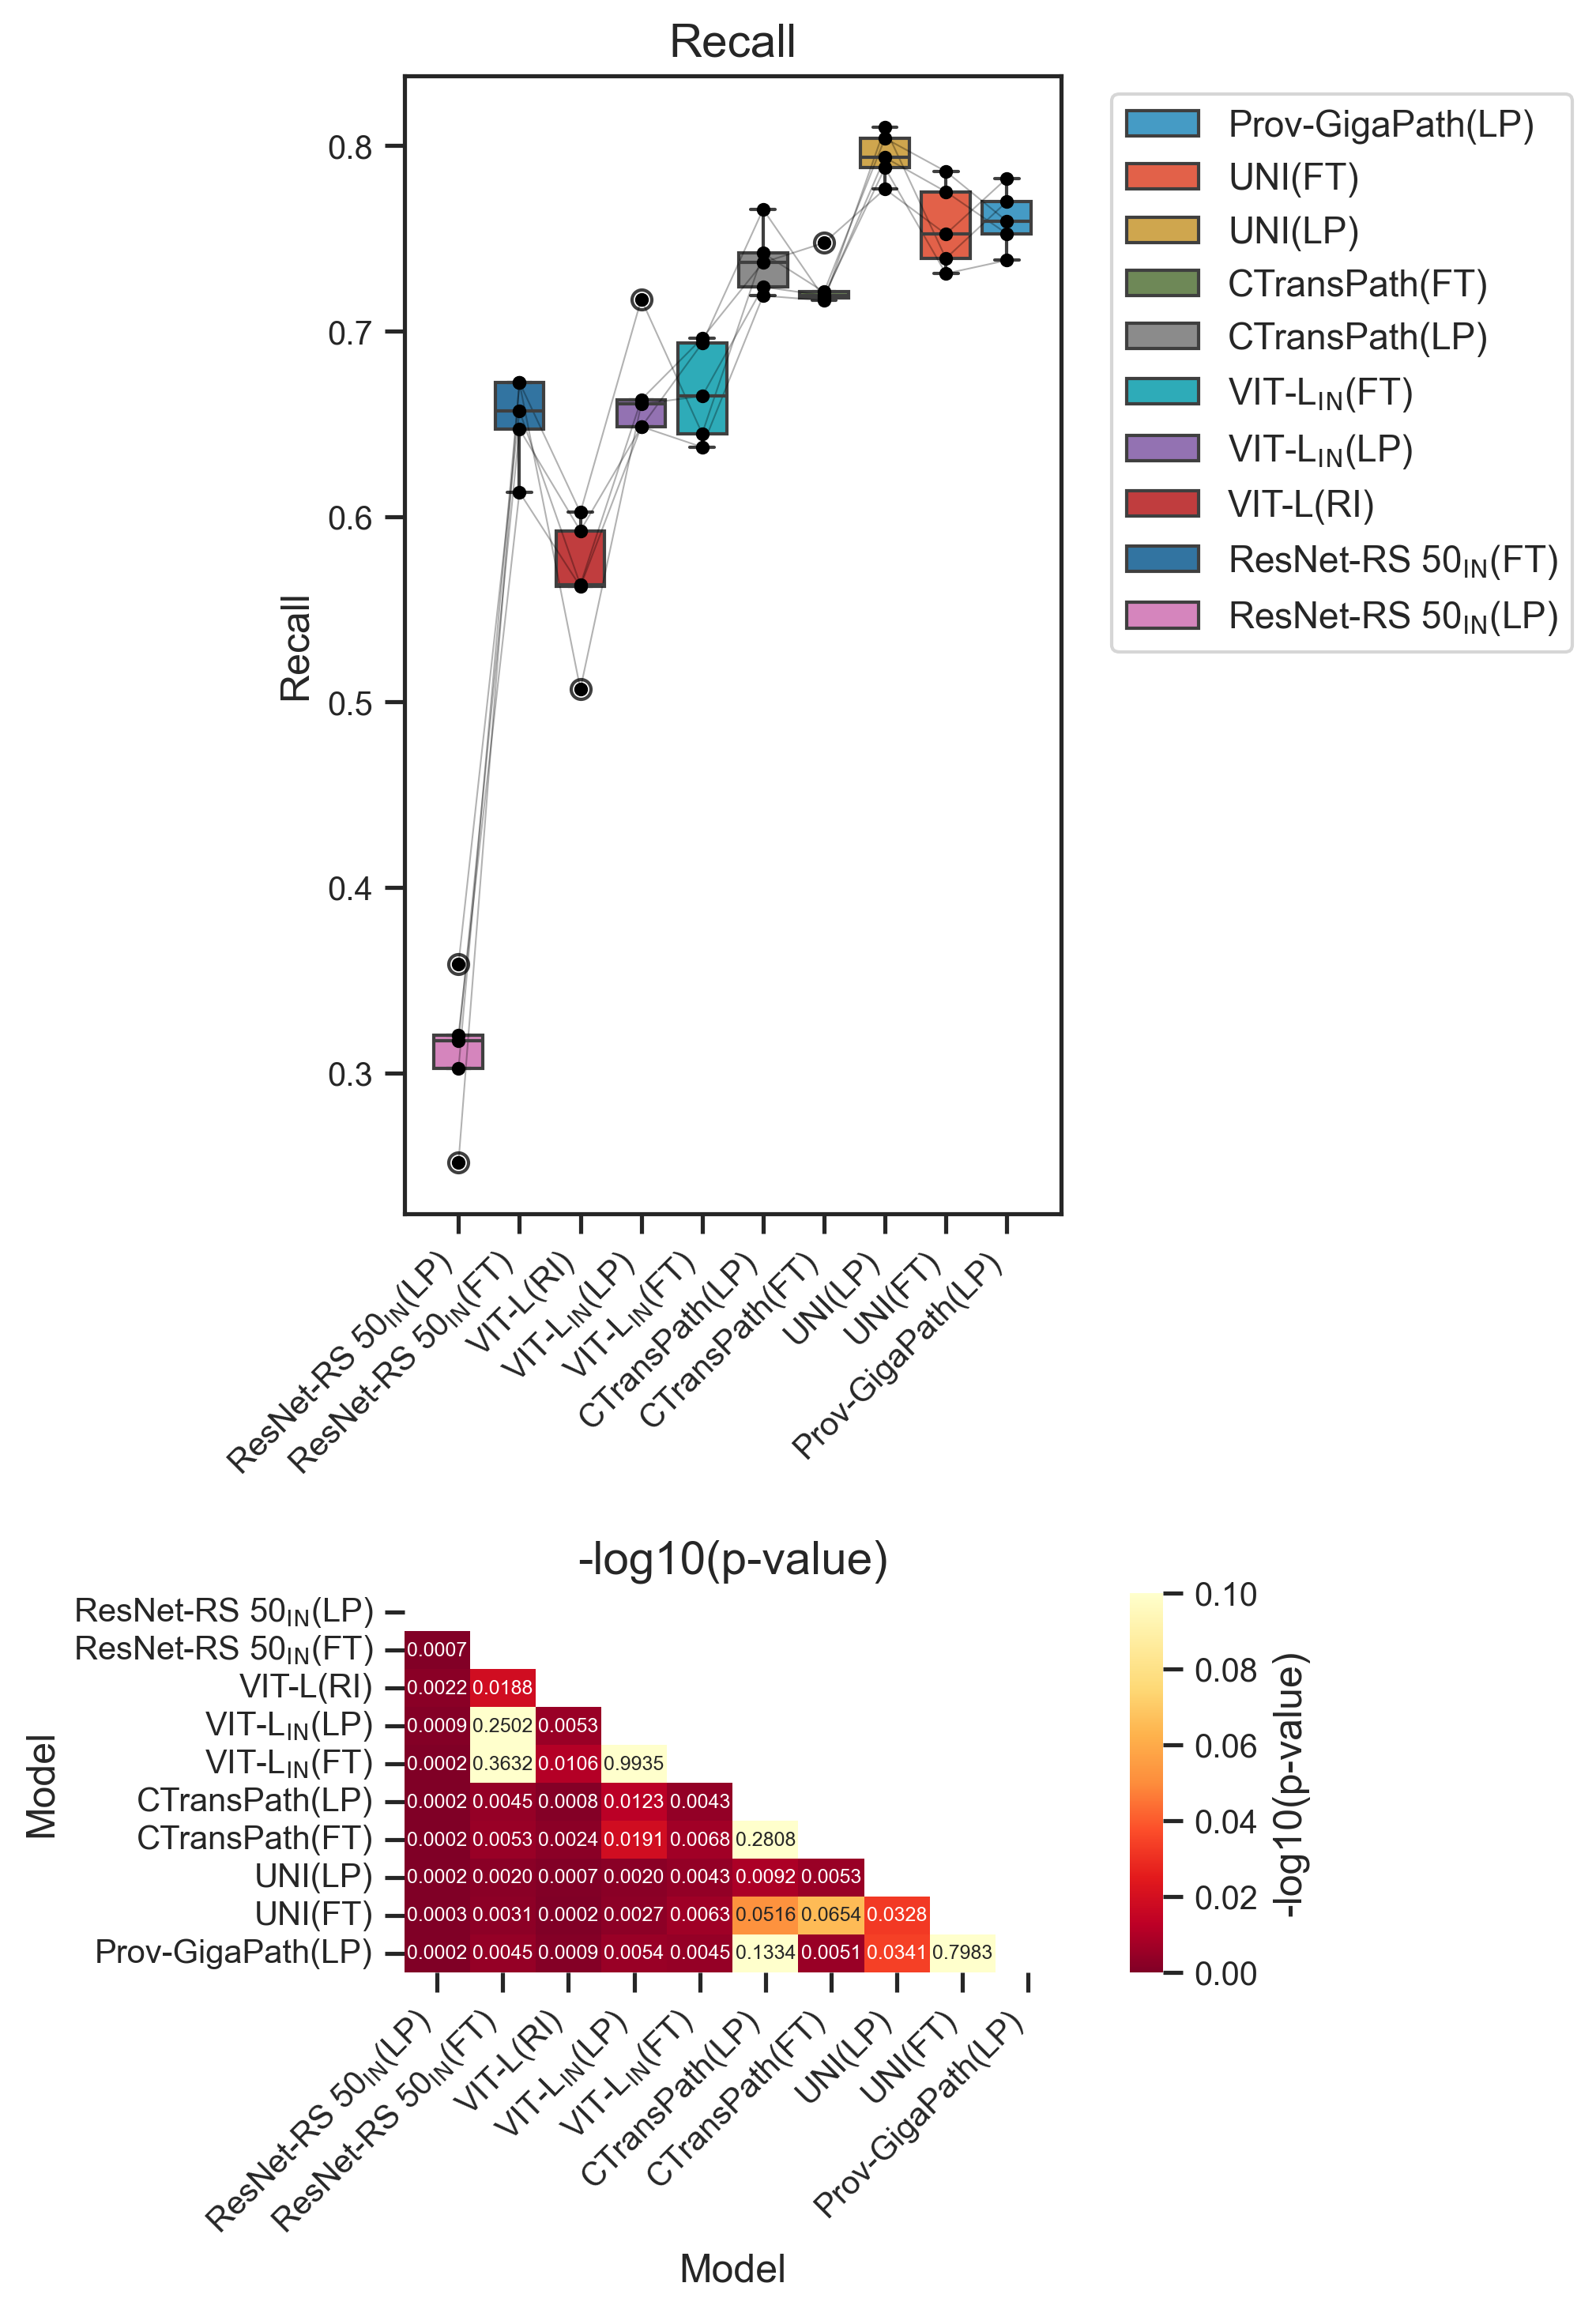

ebrains - fine - 500 - acc
saved out/figs/box_cv_fine_500_acc.png
ebrains - fine - 500 - f1
saved out/figs/box_cv_fine_500_f1.png
ebrains - coarse - 500 - pacc
saved out/figs/box_cv_coarse_500_pacc.png


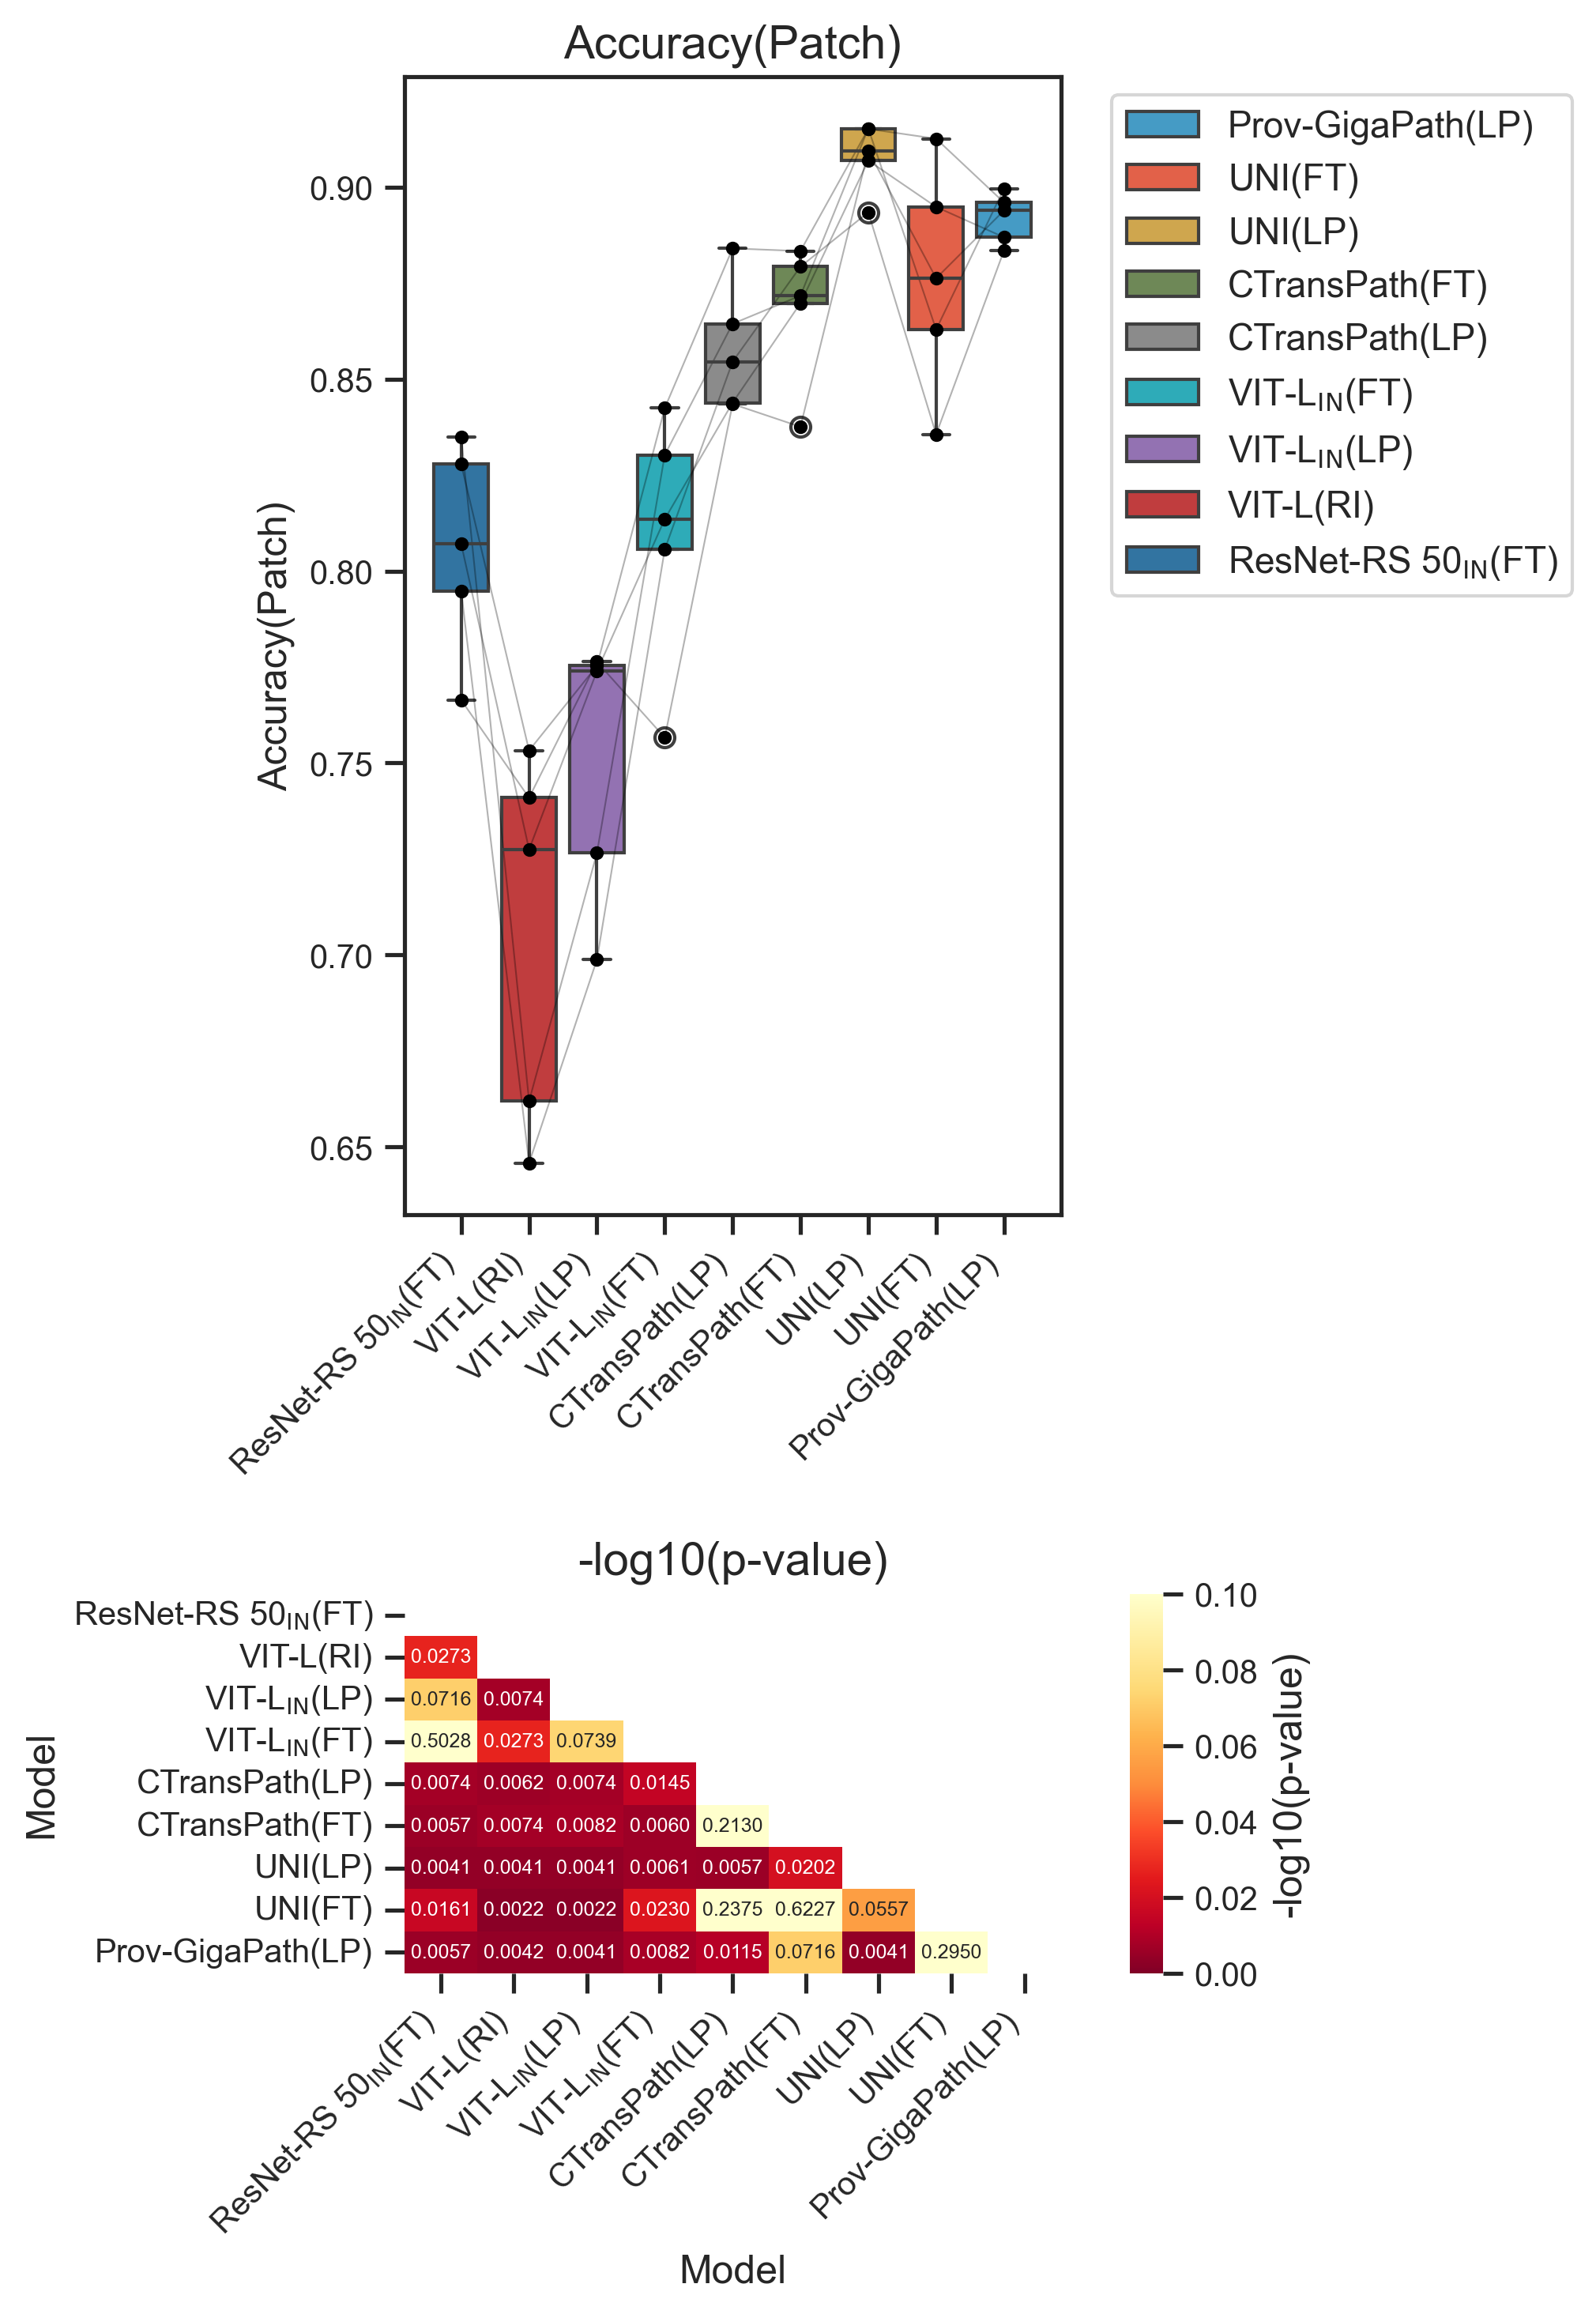

ebrains - coarse - 500 - recall
saved out/figs/box_cv_coarse_500_recall.png


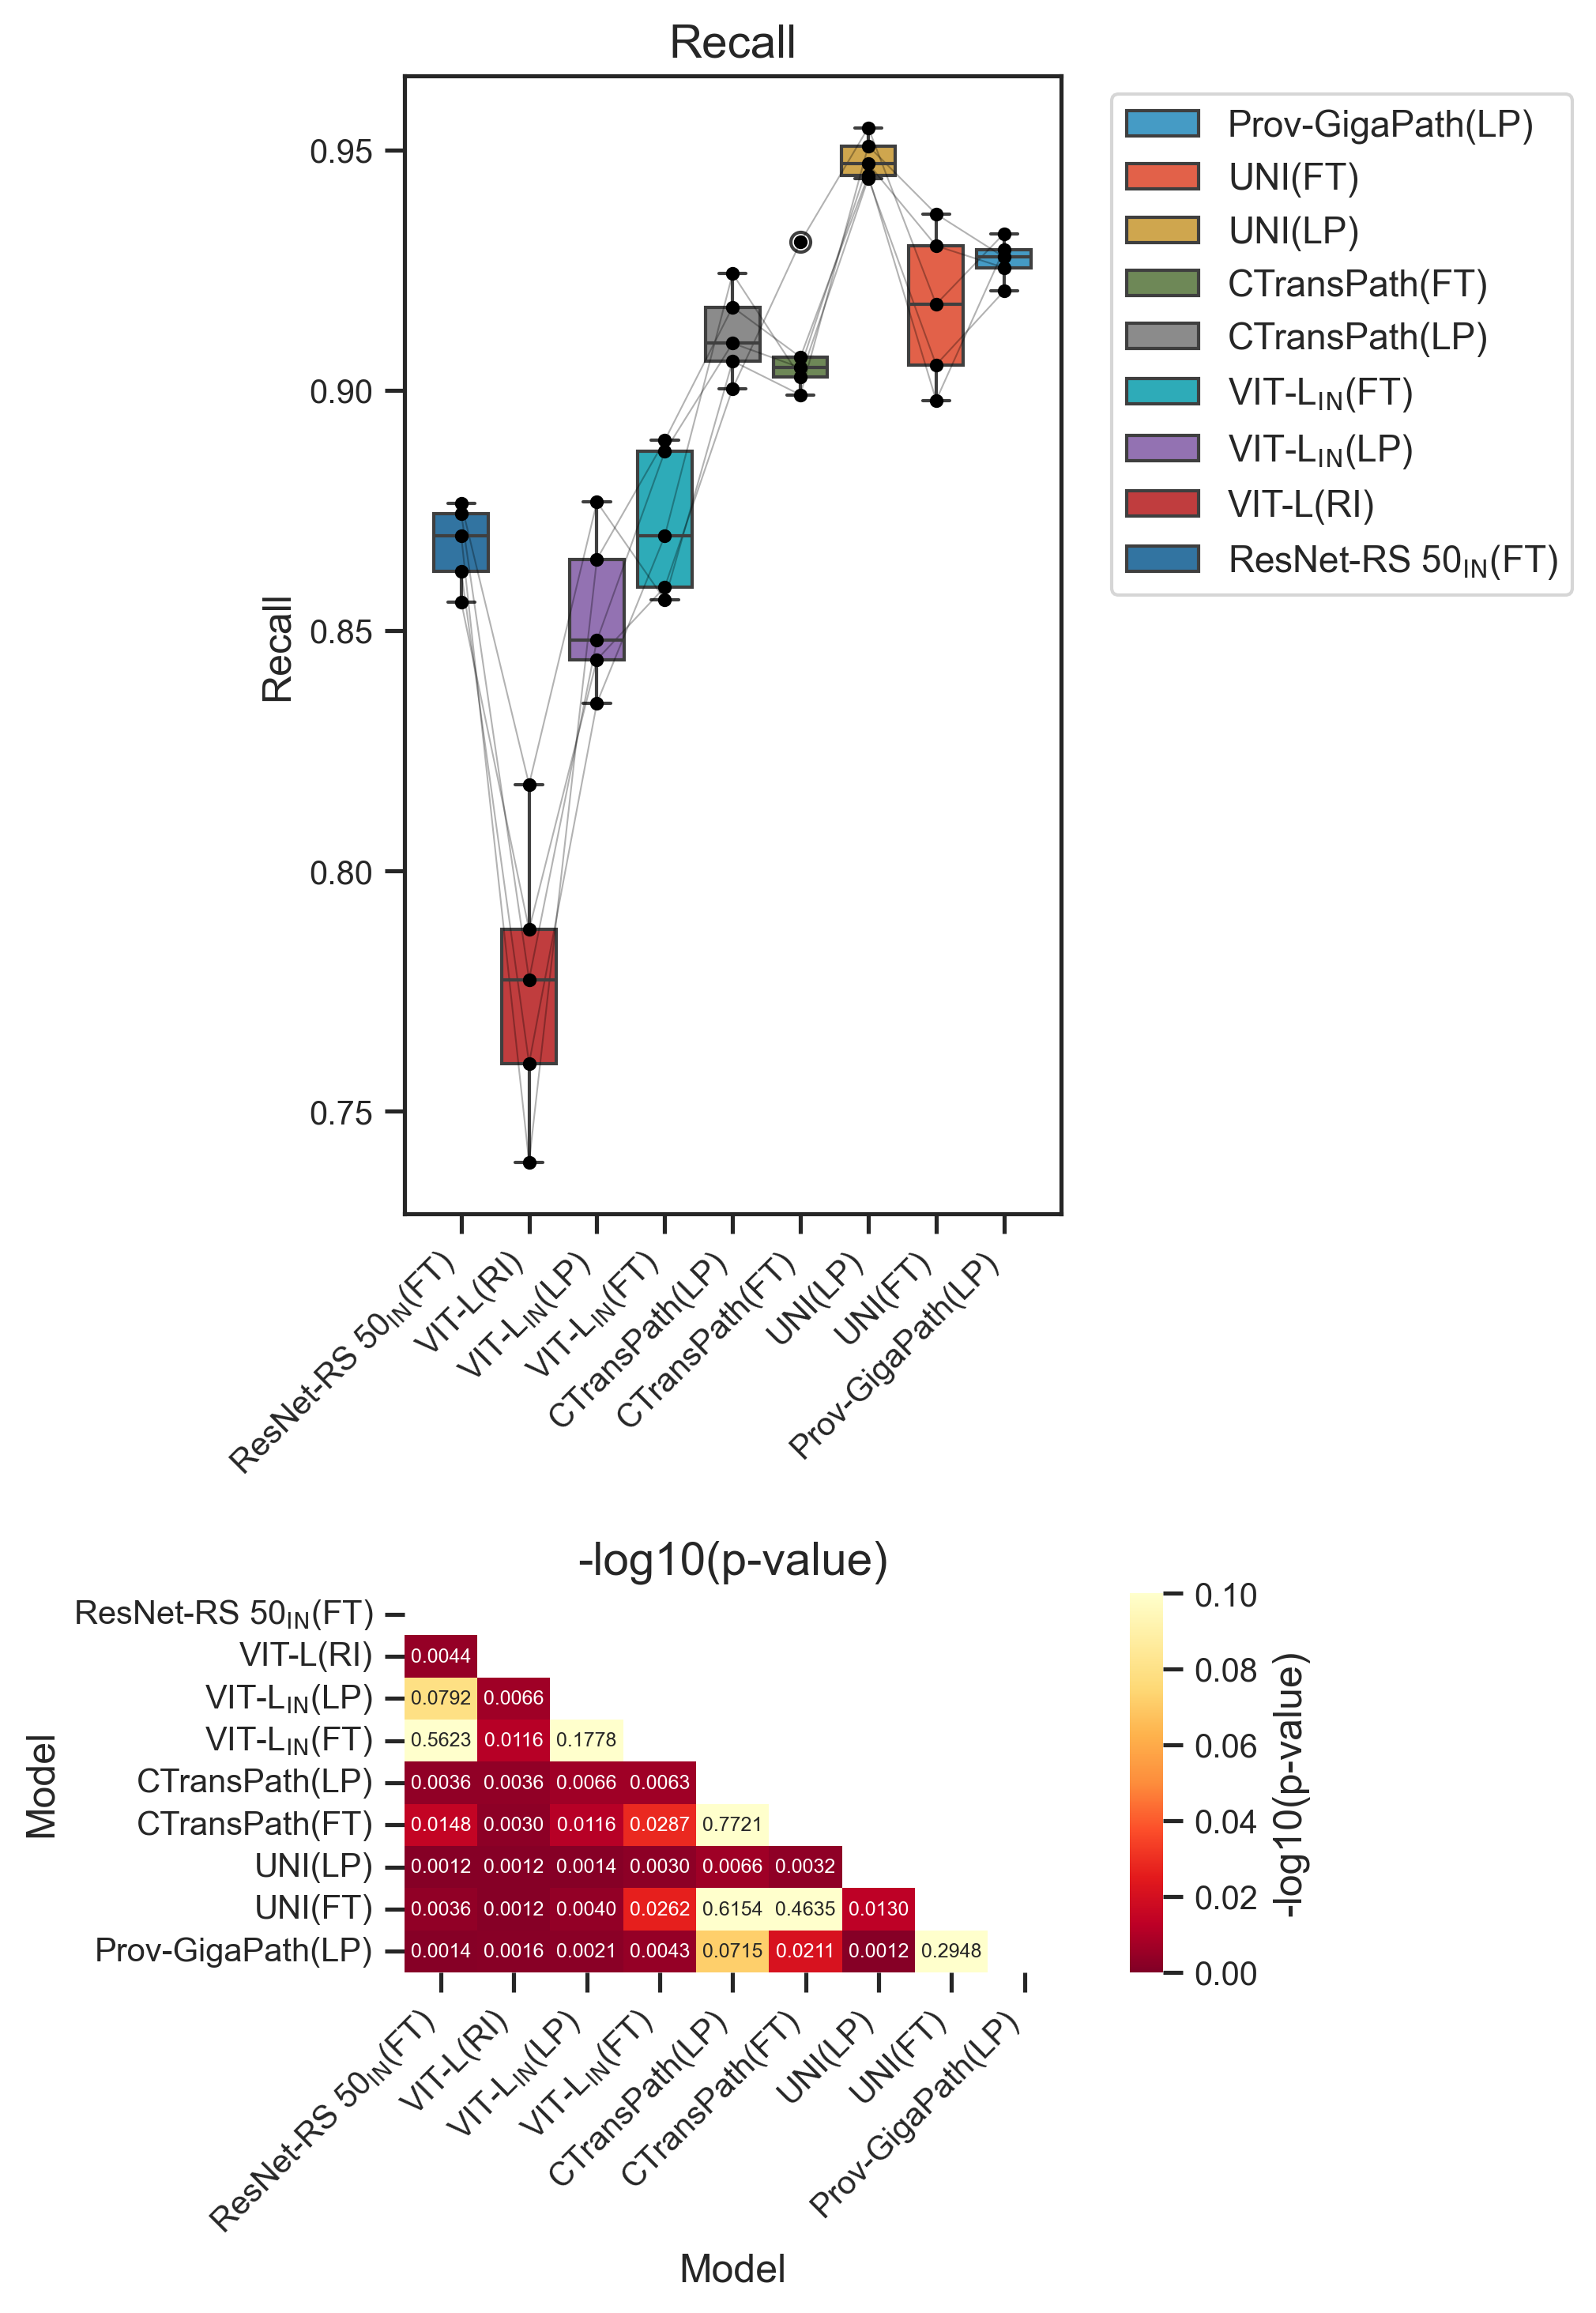

ebrains - coarse - 500 - acc
saved out/figs/box_cv_coarse_500_acc.png
ebrains - coarse - 500 - f1
saved out/figs/box_cv_coarse_500_f1.png


In [19]:
paired_box('ebrains', False, LIMIT, 'pacc', True, excludes=[])
paired_box('ebrains', False, LIMIT, 'recall', True, excludes=[])
paired_box('ebrains', False, LIMIT, 'acc')
paired_box('ebrains', False, LIMIT, 'f1')

paired_box('ebrains', True, LIMIT, 'pacc', True)
paired_box('ebrains', True, LIMIT, 'recall', True)
paired_box('ebrains', True, LIMIT, 'acc')
paired_box('ebrains', True, LIMIT, 'f1')

#### fig4

This fig shows the impact of patch number per case on model performace

In [11]:
def draw_lines(target, key:str, coarse:bool, fill=False, show=False):
    labels = [
        r'Prov-GigaPath(LP)',
        r'UNI(FT)',
        r'UNI(LP)',
        r'CTransPath(FT)',
        r'CTransPath(LP)',
        r'VIT-L$\mathrm{_{IN}}$(FT)',
        r'VIT-L$\mathrm{_{IN}}$(LP)',
        r'VIT-L(RI)',
        r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
        # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    ]

    grains = 'coarse' if coarse else 'fine'
    key_label = {
        'pacc': 'Accuracy(Patch)',
        'recall': 'Recall',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }[key]
    
    # color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    # color_map = dict(zip(label_order, sns.color_palette(PALETTE, n_colors=len(label_order))))
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        # if labels is None:
        #     if limit == limits[0]:
        #         # sort on 10 limit
        #         df_mean = df.groupby('label')[key].mean().sort_values(ascending=True)
        #         df[f'average_{key}'] = df['label'].map(df_mean)
        #         df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
        #         labels = df['label'].unique()[::-1]

        for label in labels:
            scores = df[df['label']==label][key_label]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            # CI
            # diff = stats.t.interval(1 - alpha, df=len(scores)-1, loc=mean, scale=diff)[1] - mean
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    plt.figure(figsize=(6, 7))
    x = np.arange(1, 1+len(limits))

    for i, label in enumerate(labels):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        # c = colors[i]
        c = color_map[label]
        plt.plot(x, values_by_cond[i, :, 0], color=c, label=label)
        if fill:
            plt.fill_between(x, ci_l, ci_h, color=c, alpha=0.1)
    
    plt.xticks(x, limits)
    plt.xlabel('Patch count per case')
    plt.ylabel(key_label)
    # plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(key_label)    
    plt.tight_layout()
    fig_path = f'out/figs/lines_{target}_{grains}_{key}.png'
    plt.savefig(fig_path, format="png", dpi=DPI)
    print(f'wrote {fig_path}')
    if show:
        plt.show()
    else:
        plt.close()



wrote out/figs/lines_cv_fine_pacc.png


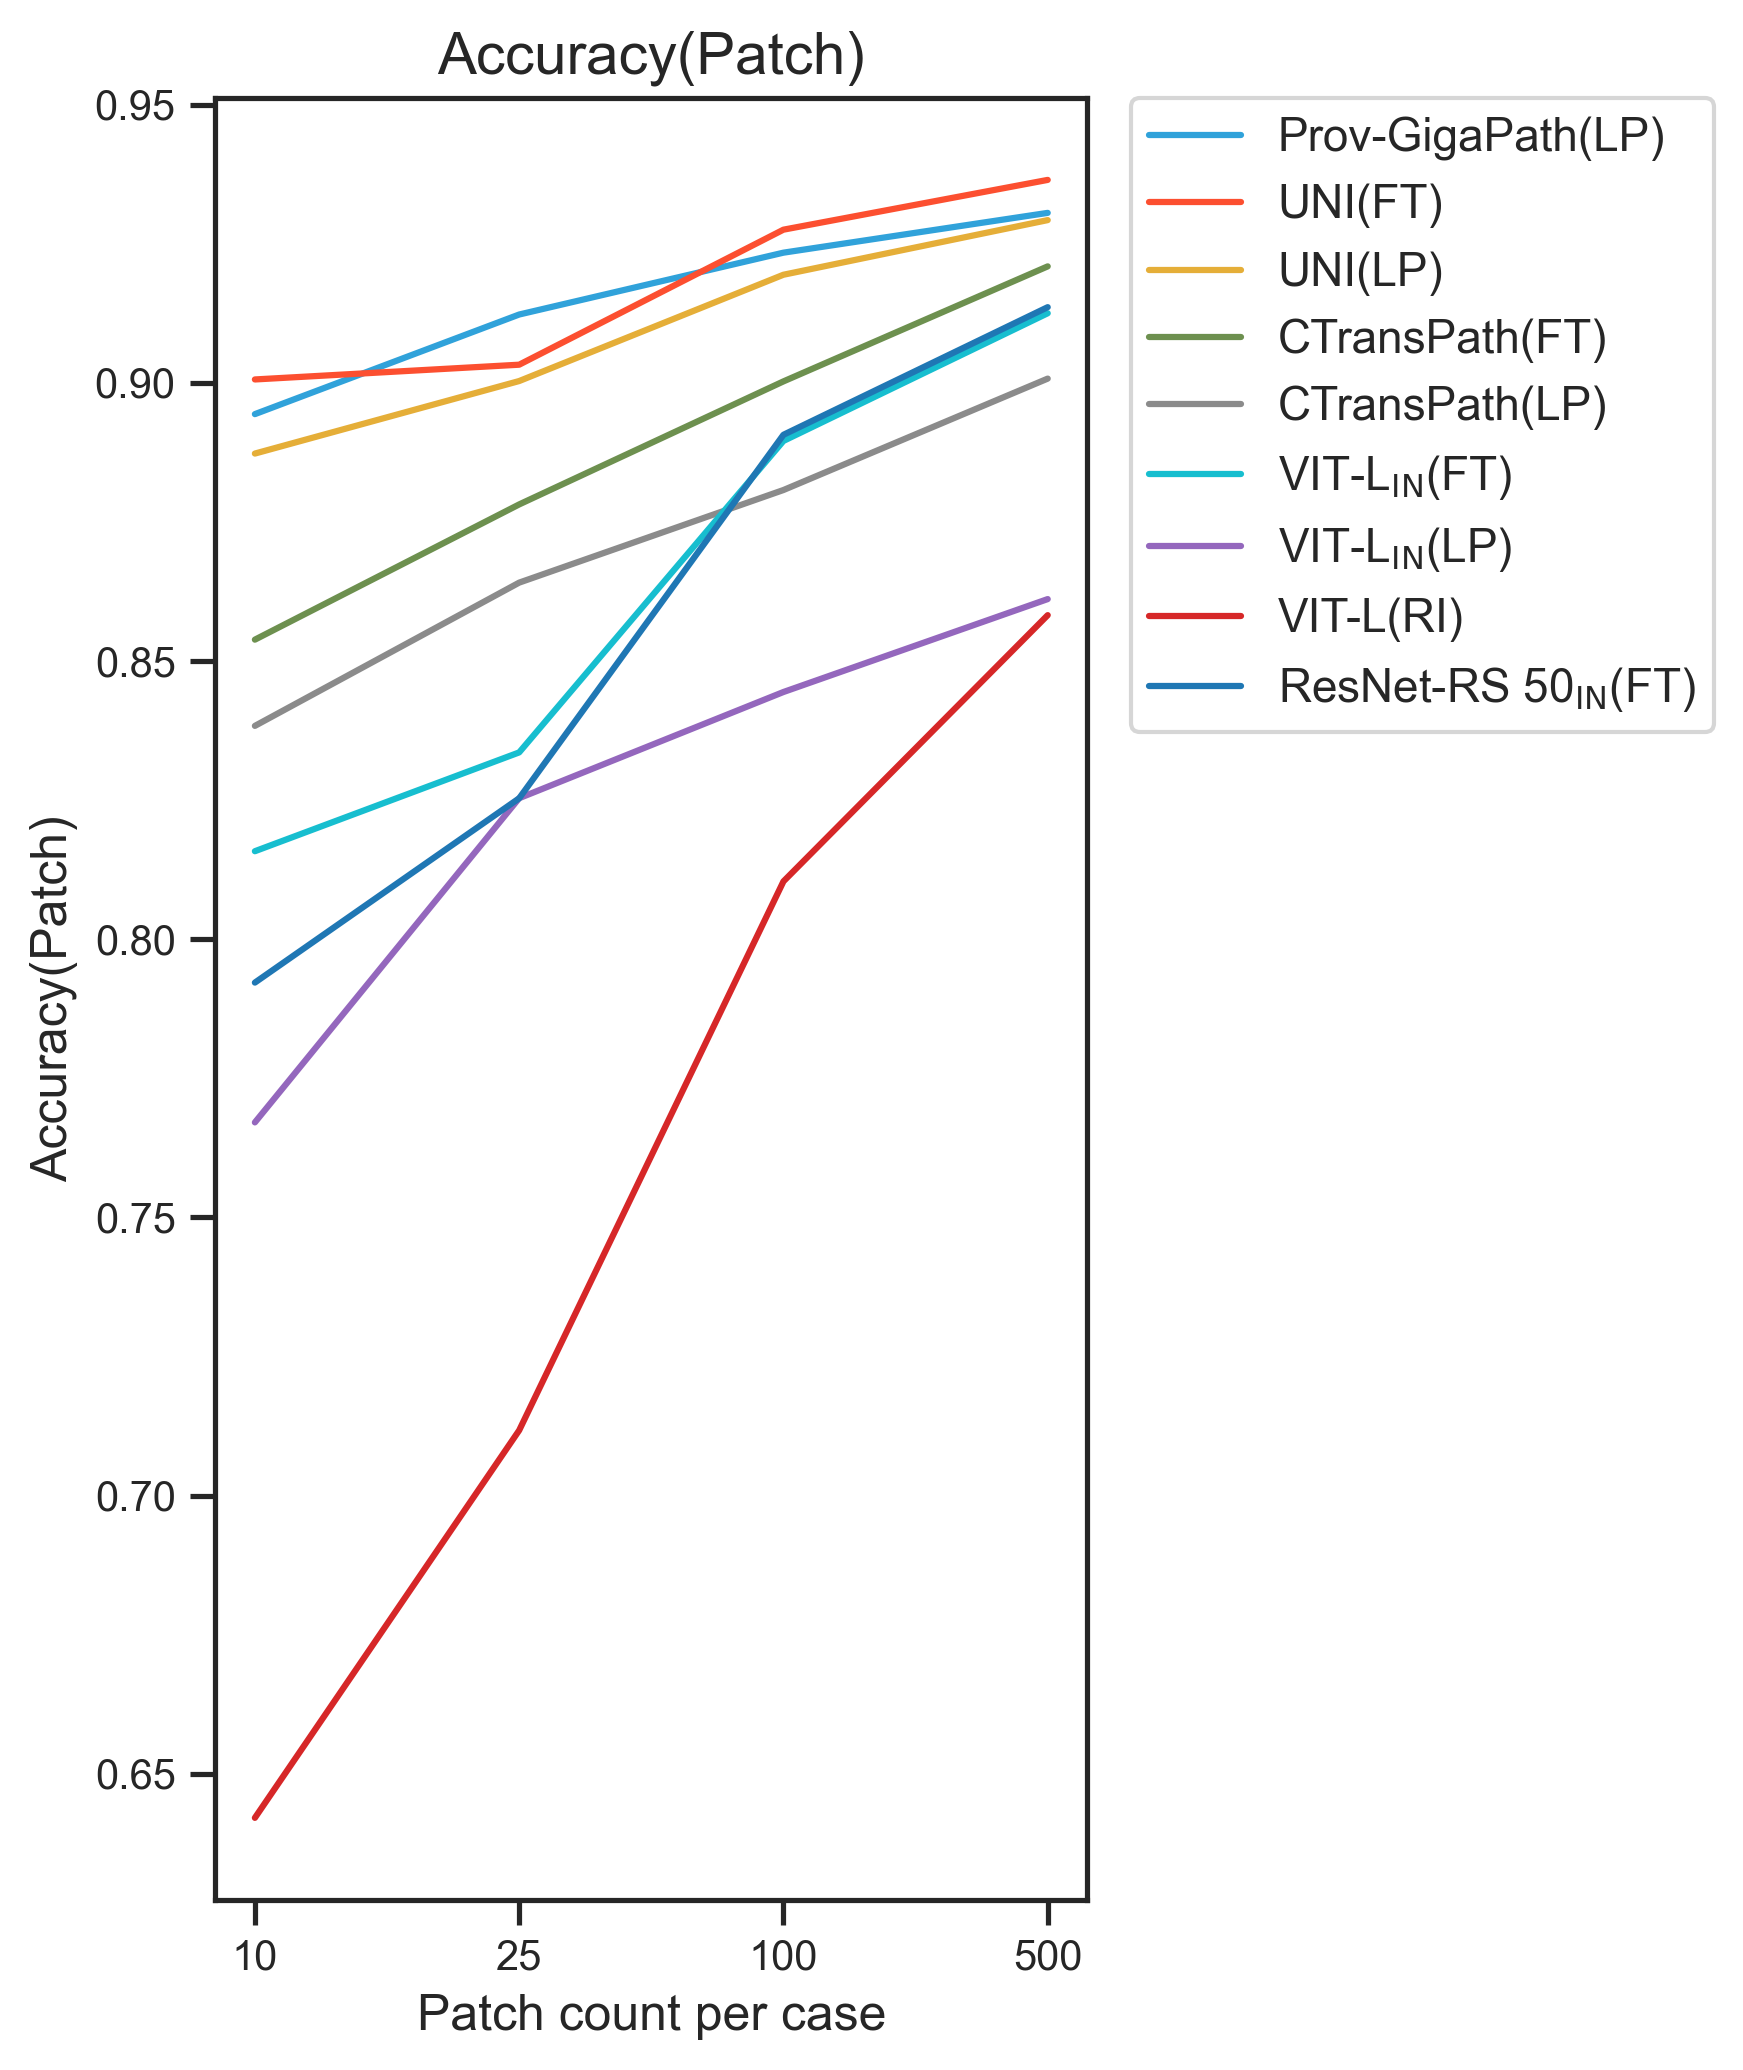

wrote out/figs/lines_cv_fine_recall.png


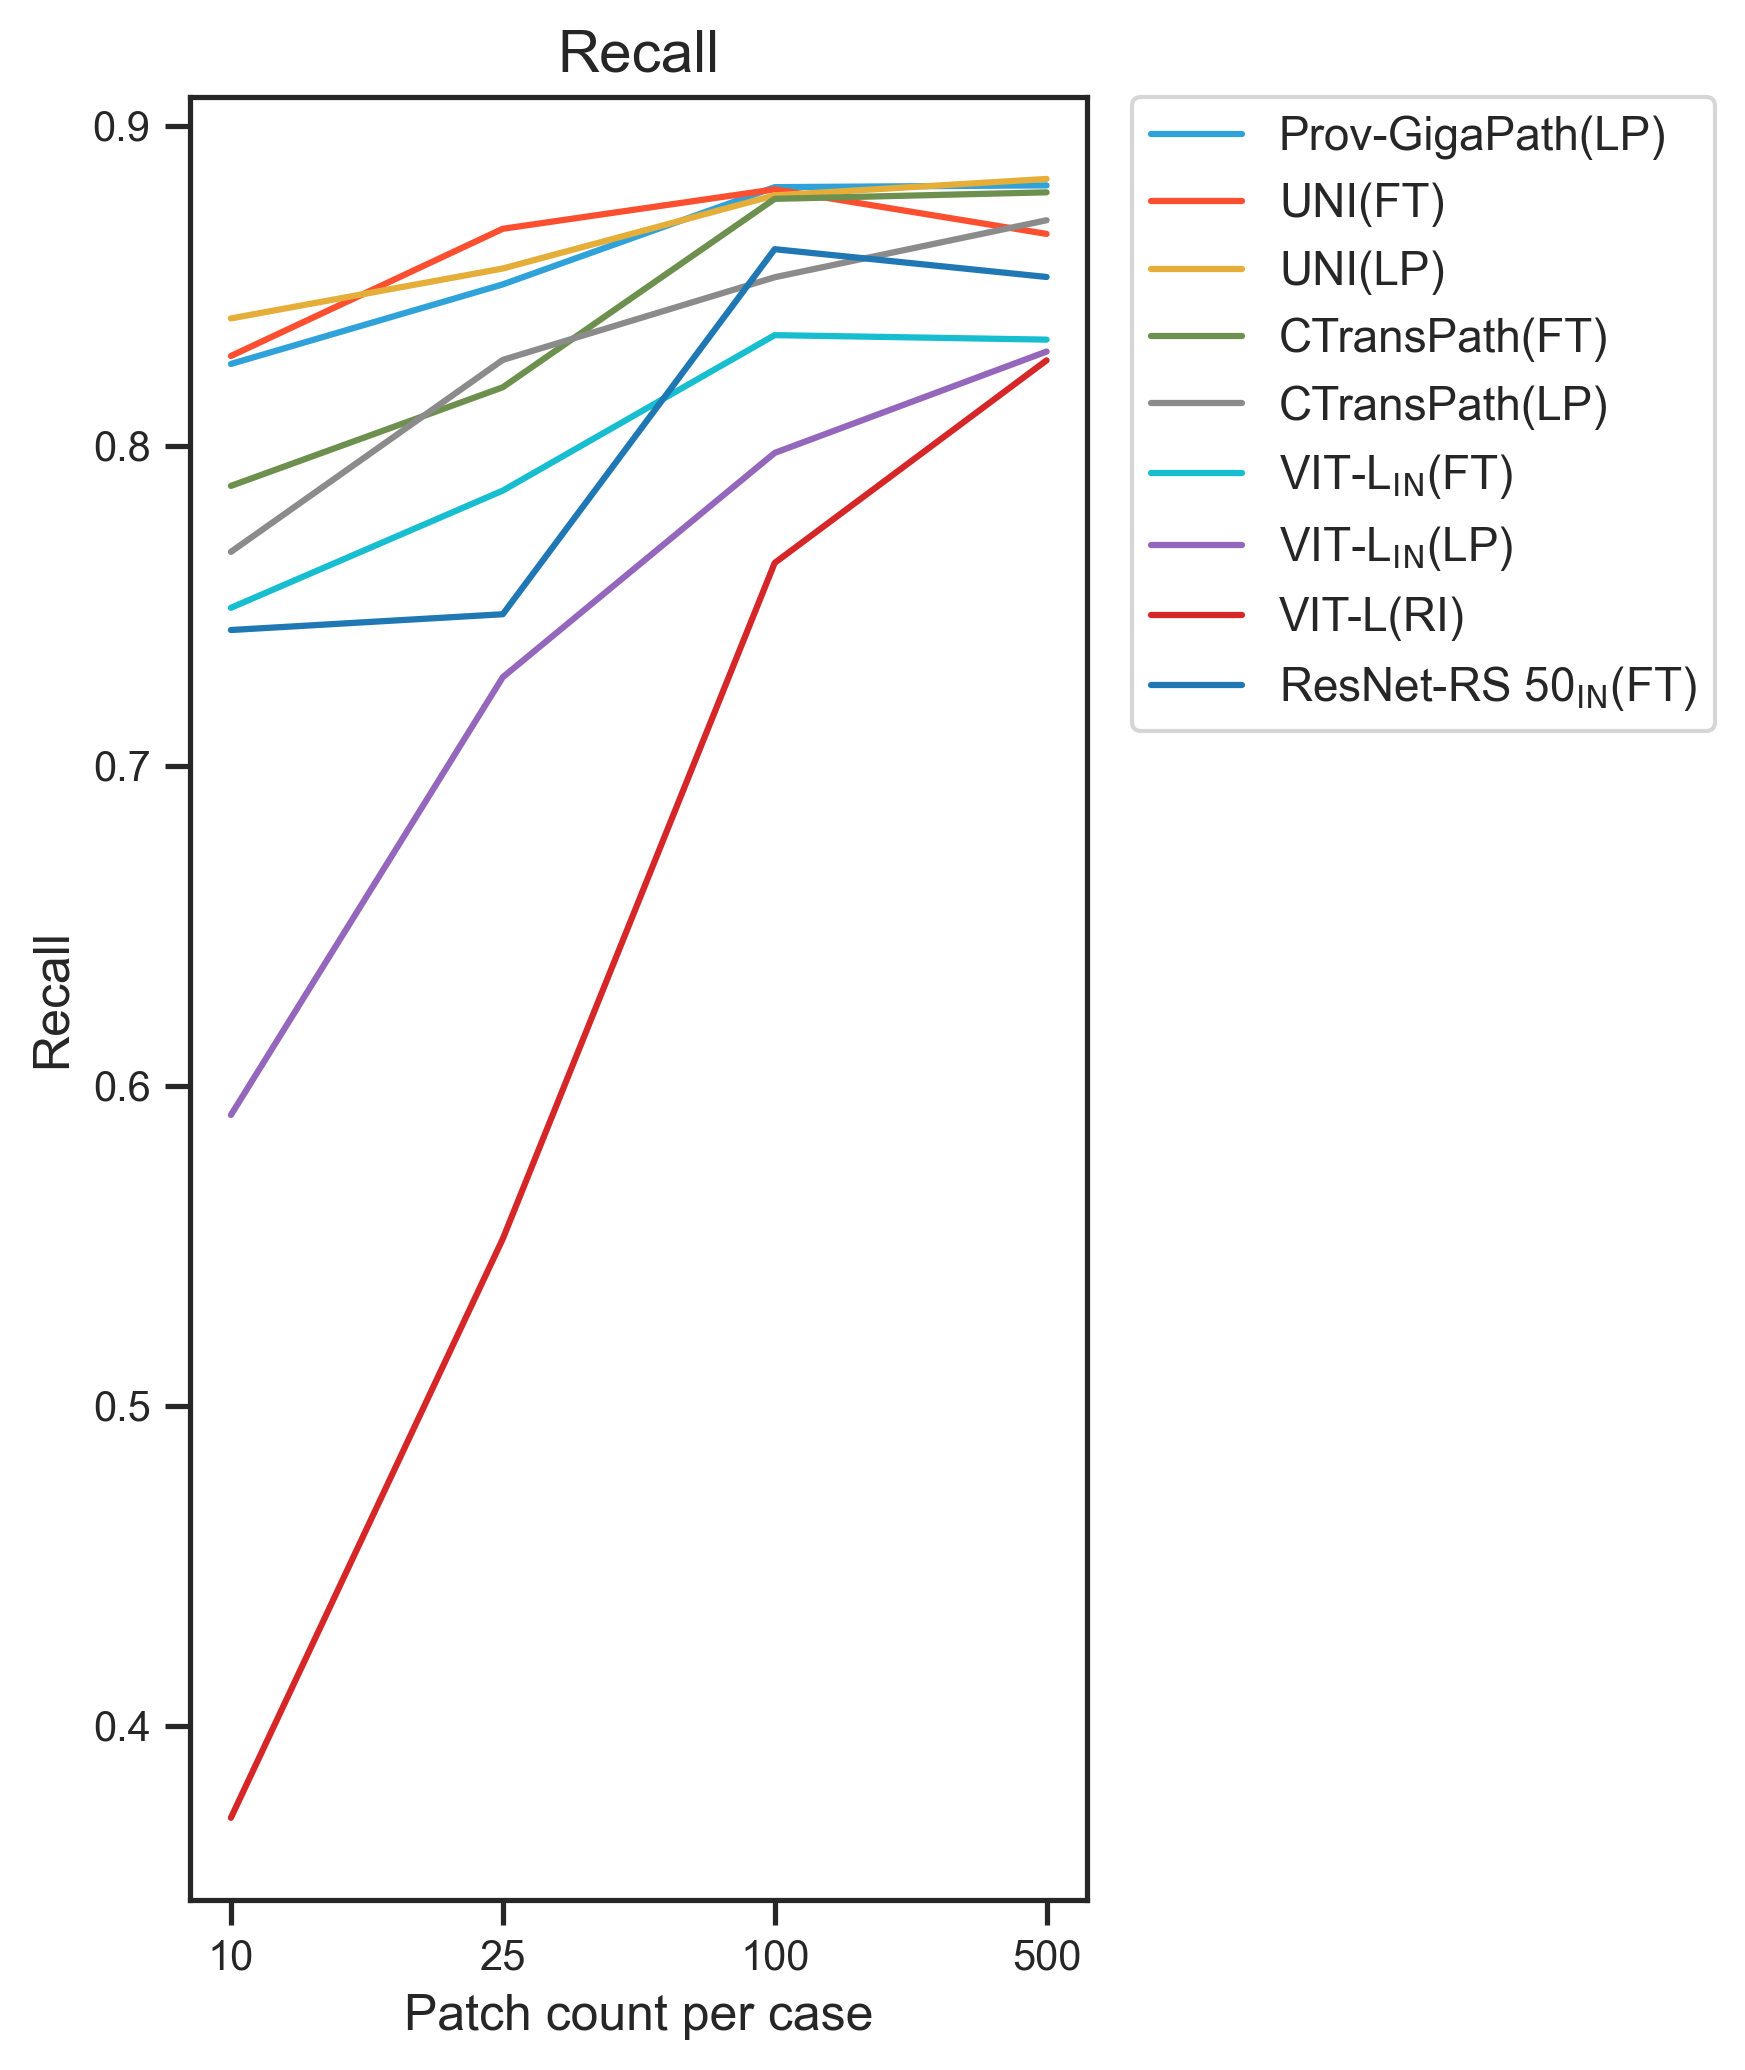

wrote out/figs/lines_cv_fine_acc.png
wrote out/figs/lines_cv_fine_f1.png
wrote out/figs/lines_cv_coarse_pacc.png


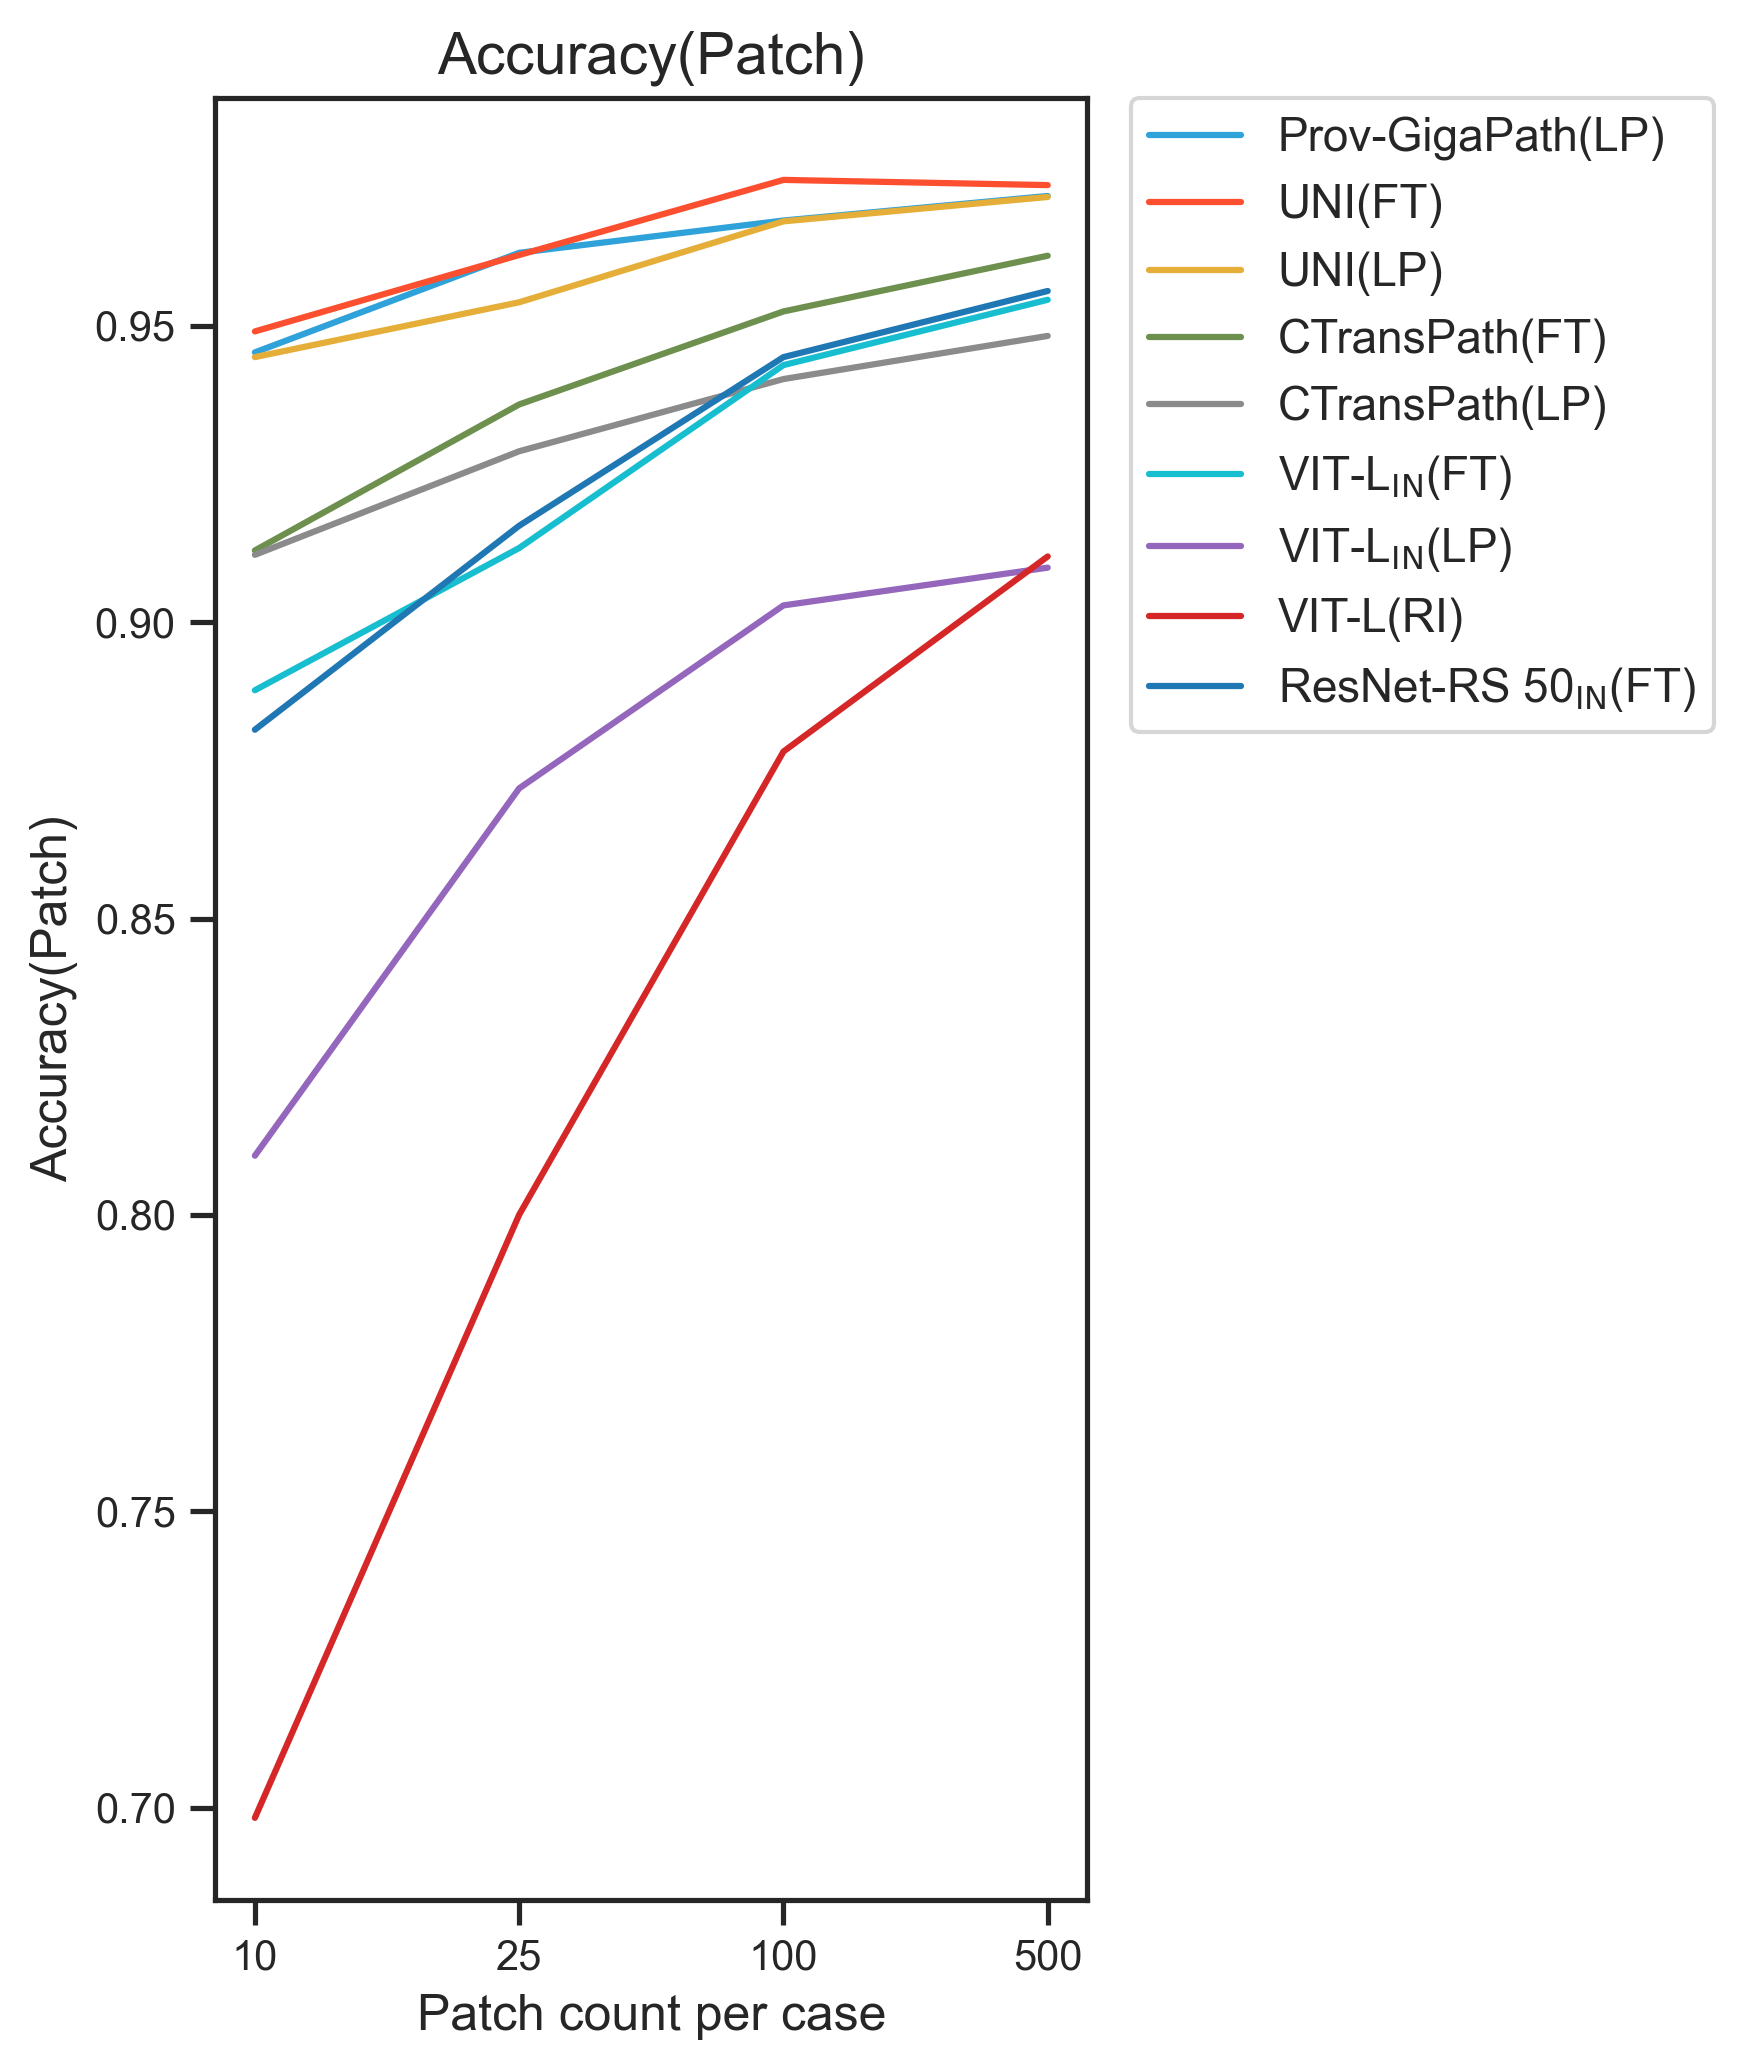

wrote out/figs/lines_cv_coarse_recall.png


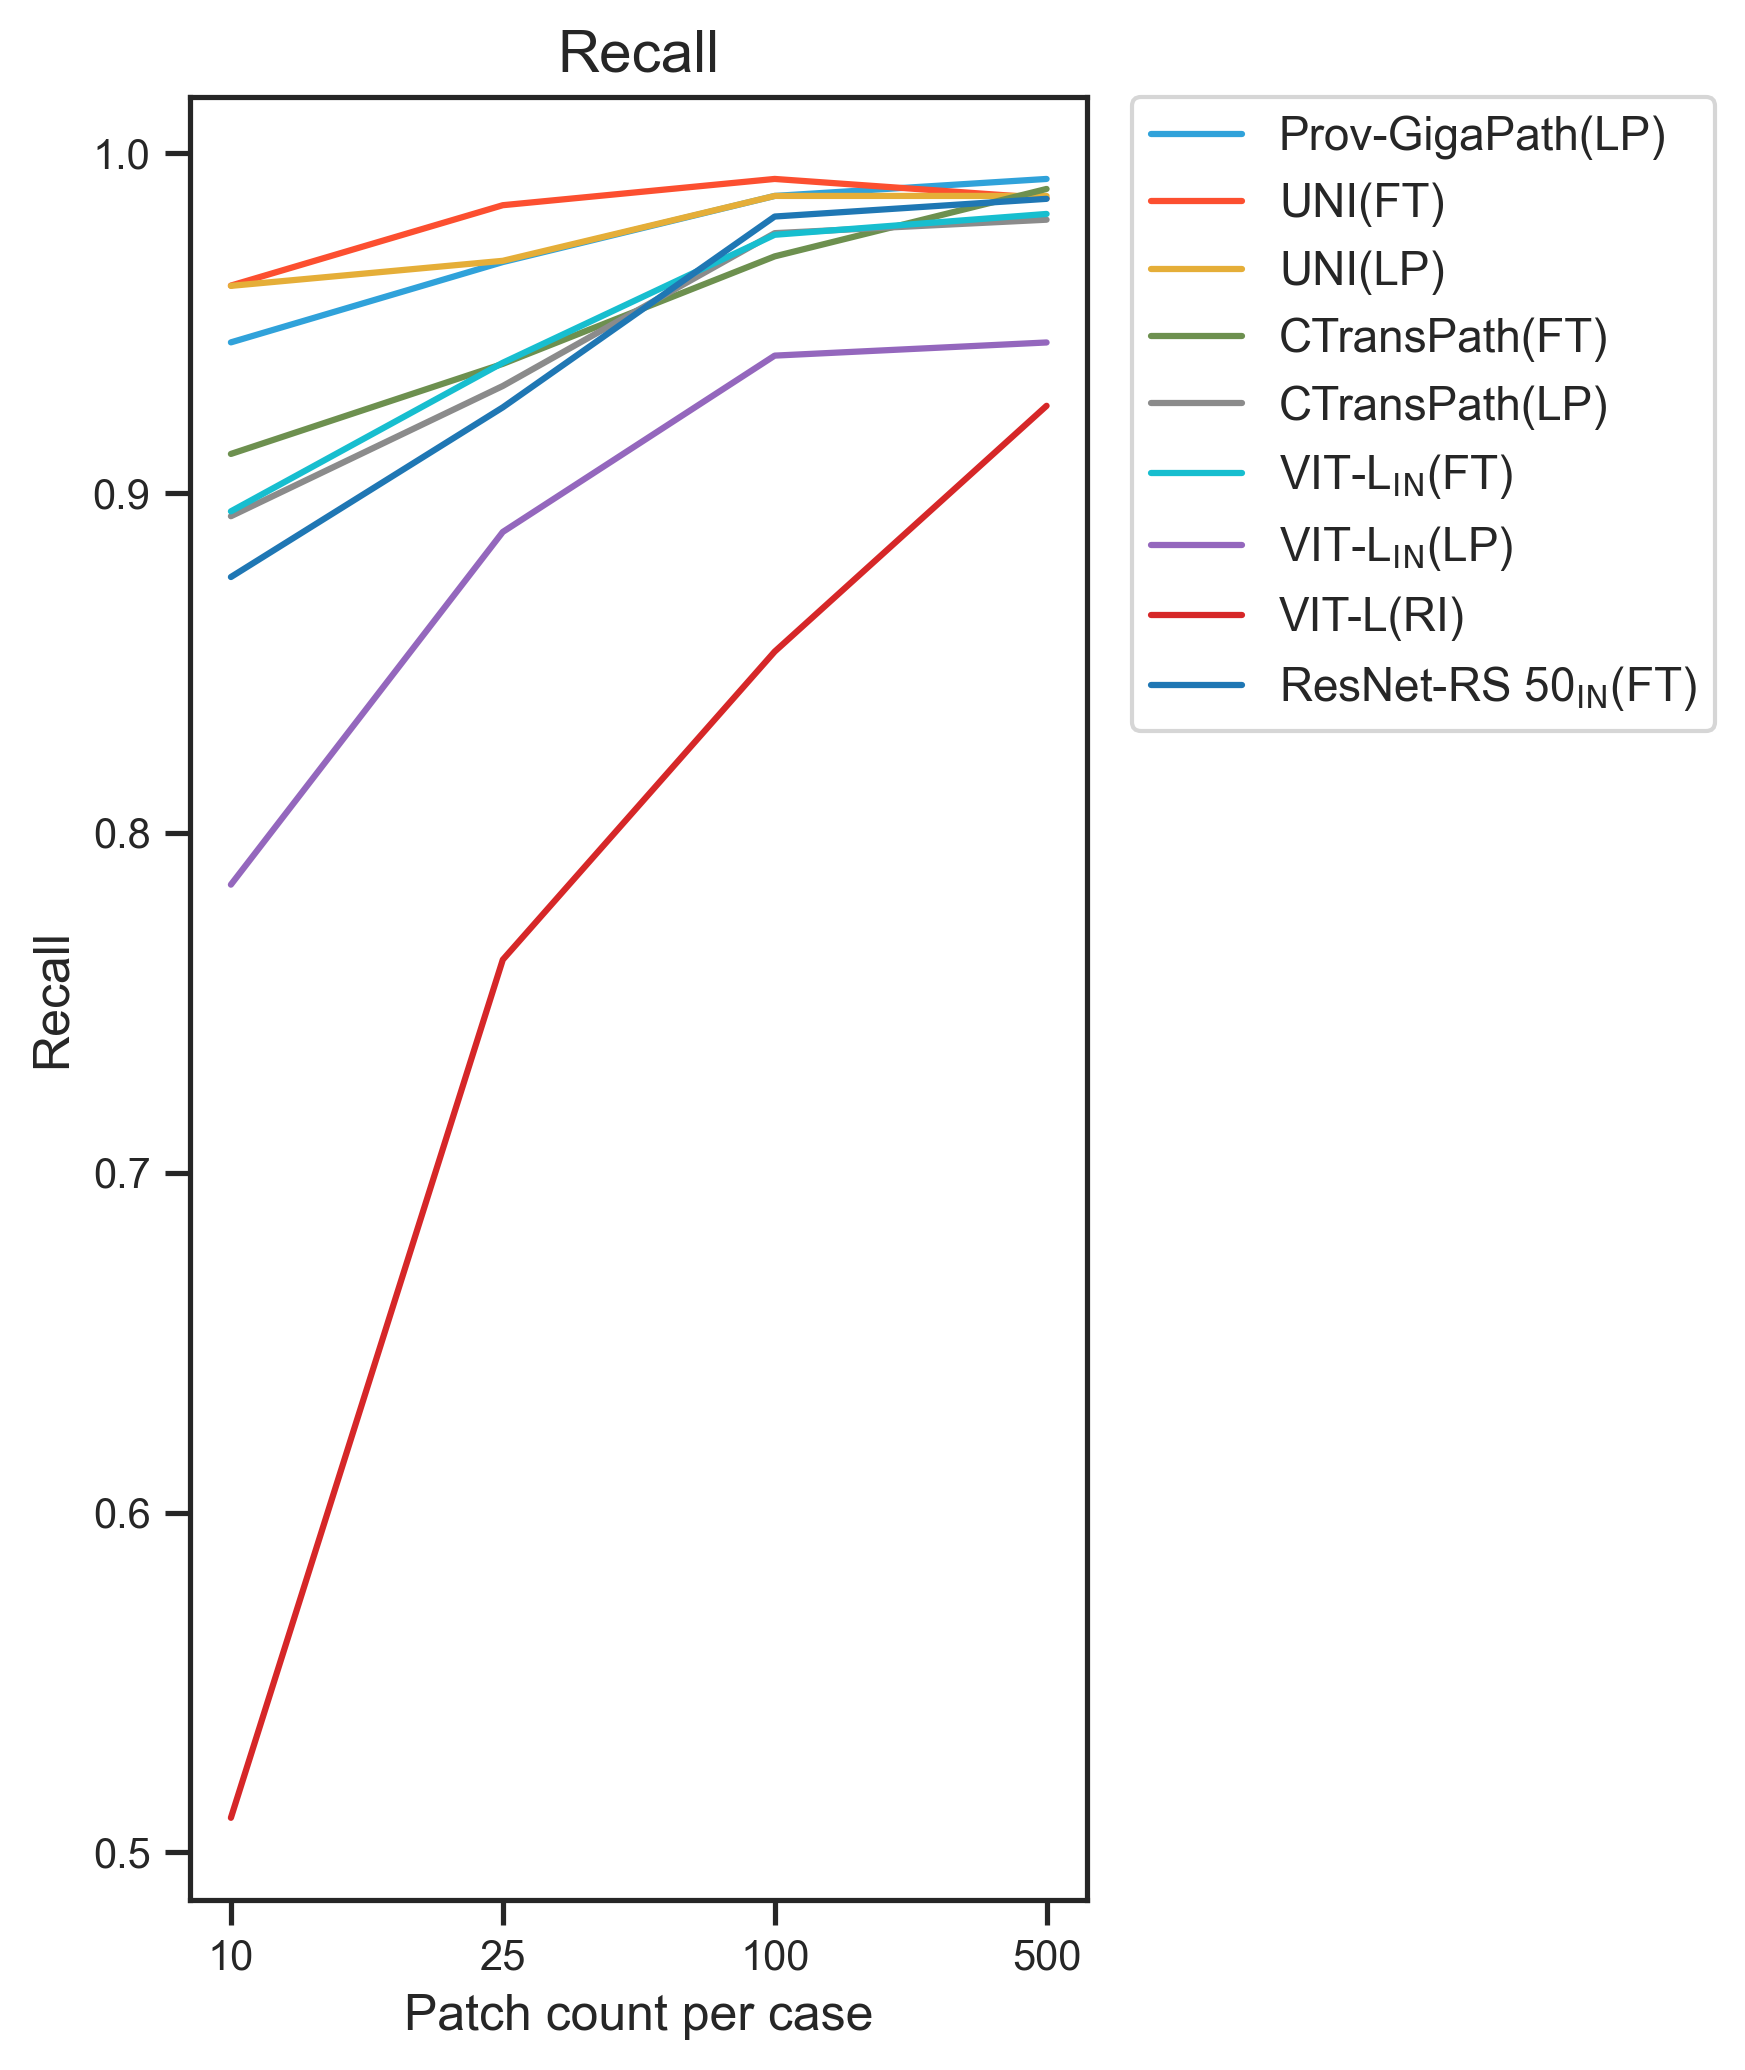

wrote out/figs/lines_cv_coarse_acc.png
wrote out/figs/lines_cv_coarse_f1.png


In [12]:
draw_lines('cv', 'pacc', False, show=True)
draw_lines('cv', 'recall', False, show=True)
draw_lines('cv', 'acc', False)
draw_lines('cv', 'f1', False)

draw_lines('cv', 'pacc', True, show=True)
draw_lines('cv', 'recall', True, show=True)
draw_lines('cv', 'acc', True)
draw_lines('cv', 'f1', True)

### Fig4: EBRAINS - lines

wrote out/figs/lines_ebrains_fine_pacc.png


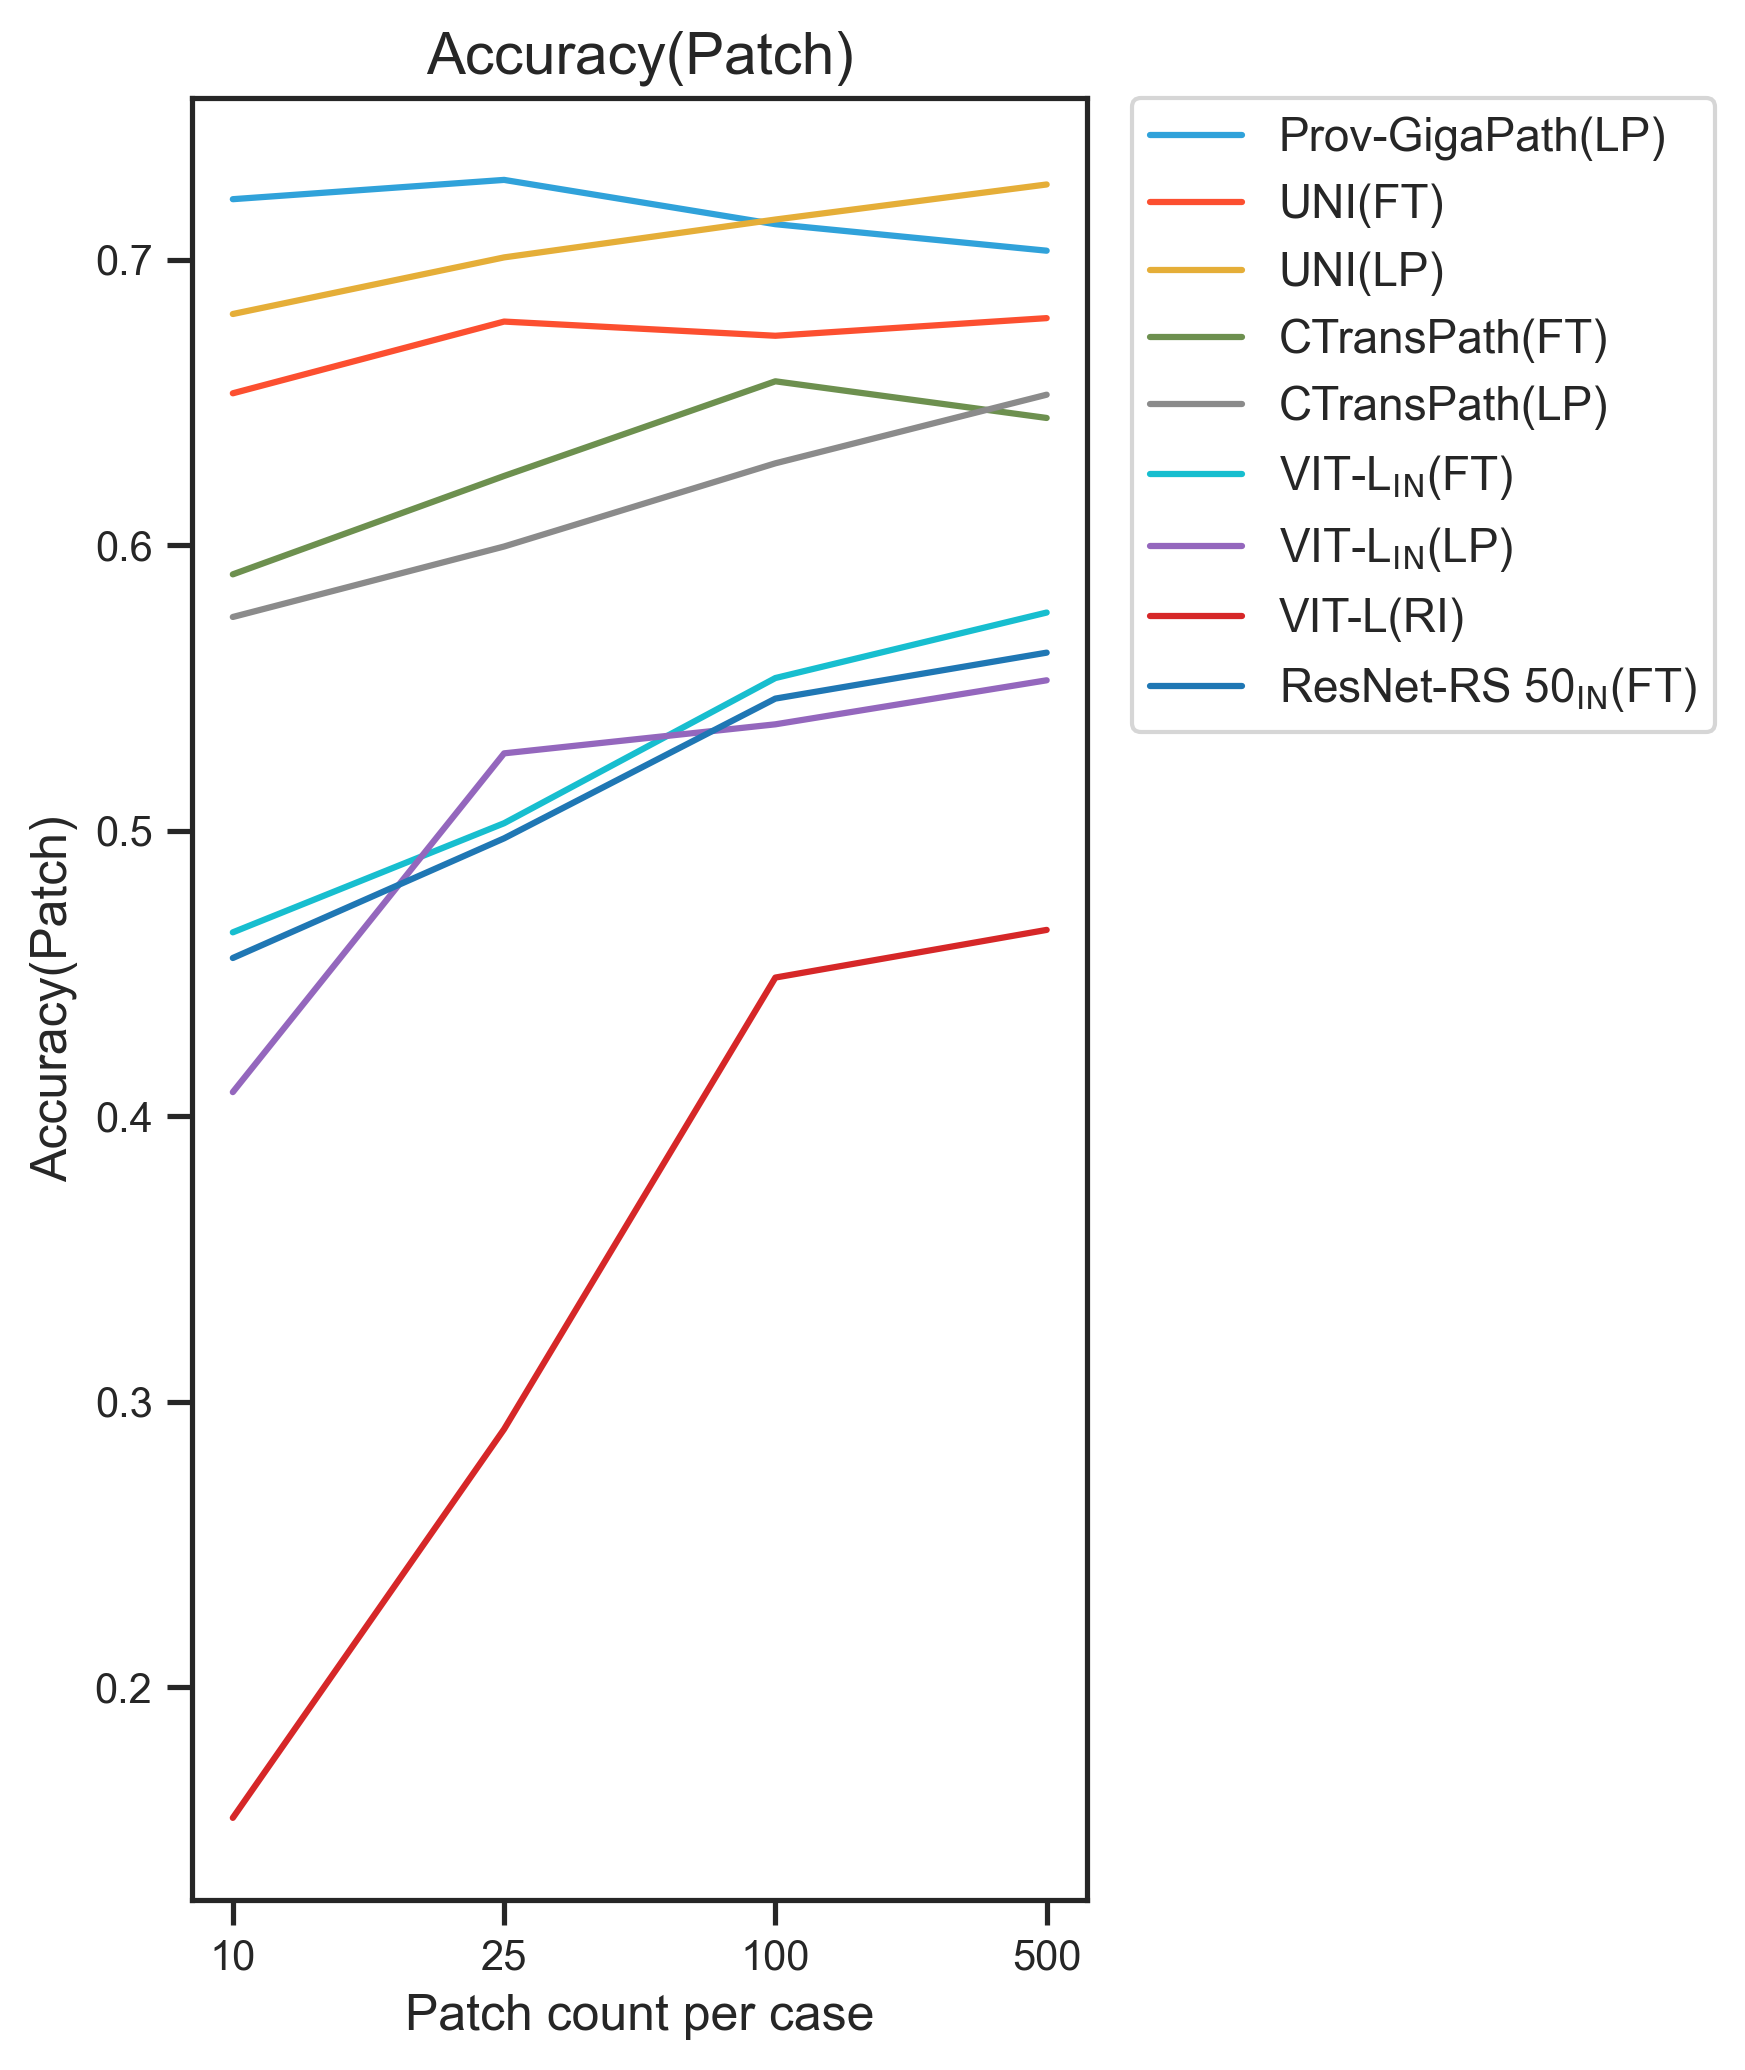

wrote out/figs/lines_ebrains_fine_acc.png
wrote out/figs/lines_ebrains_fine_f1.png
wrote out/figs/lines_ebrains_coarse_pacc.png


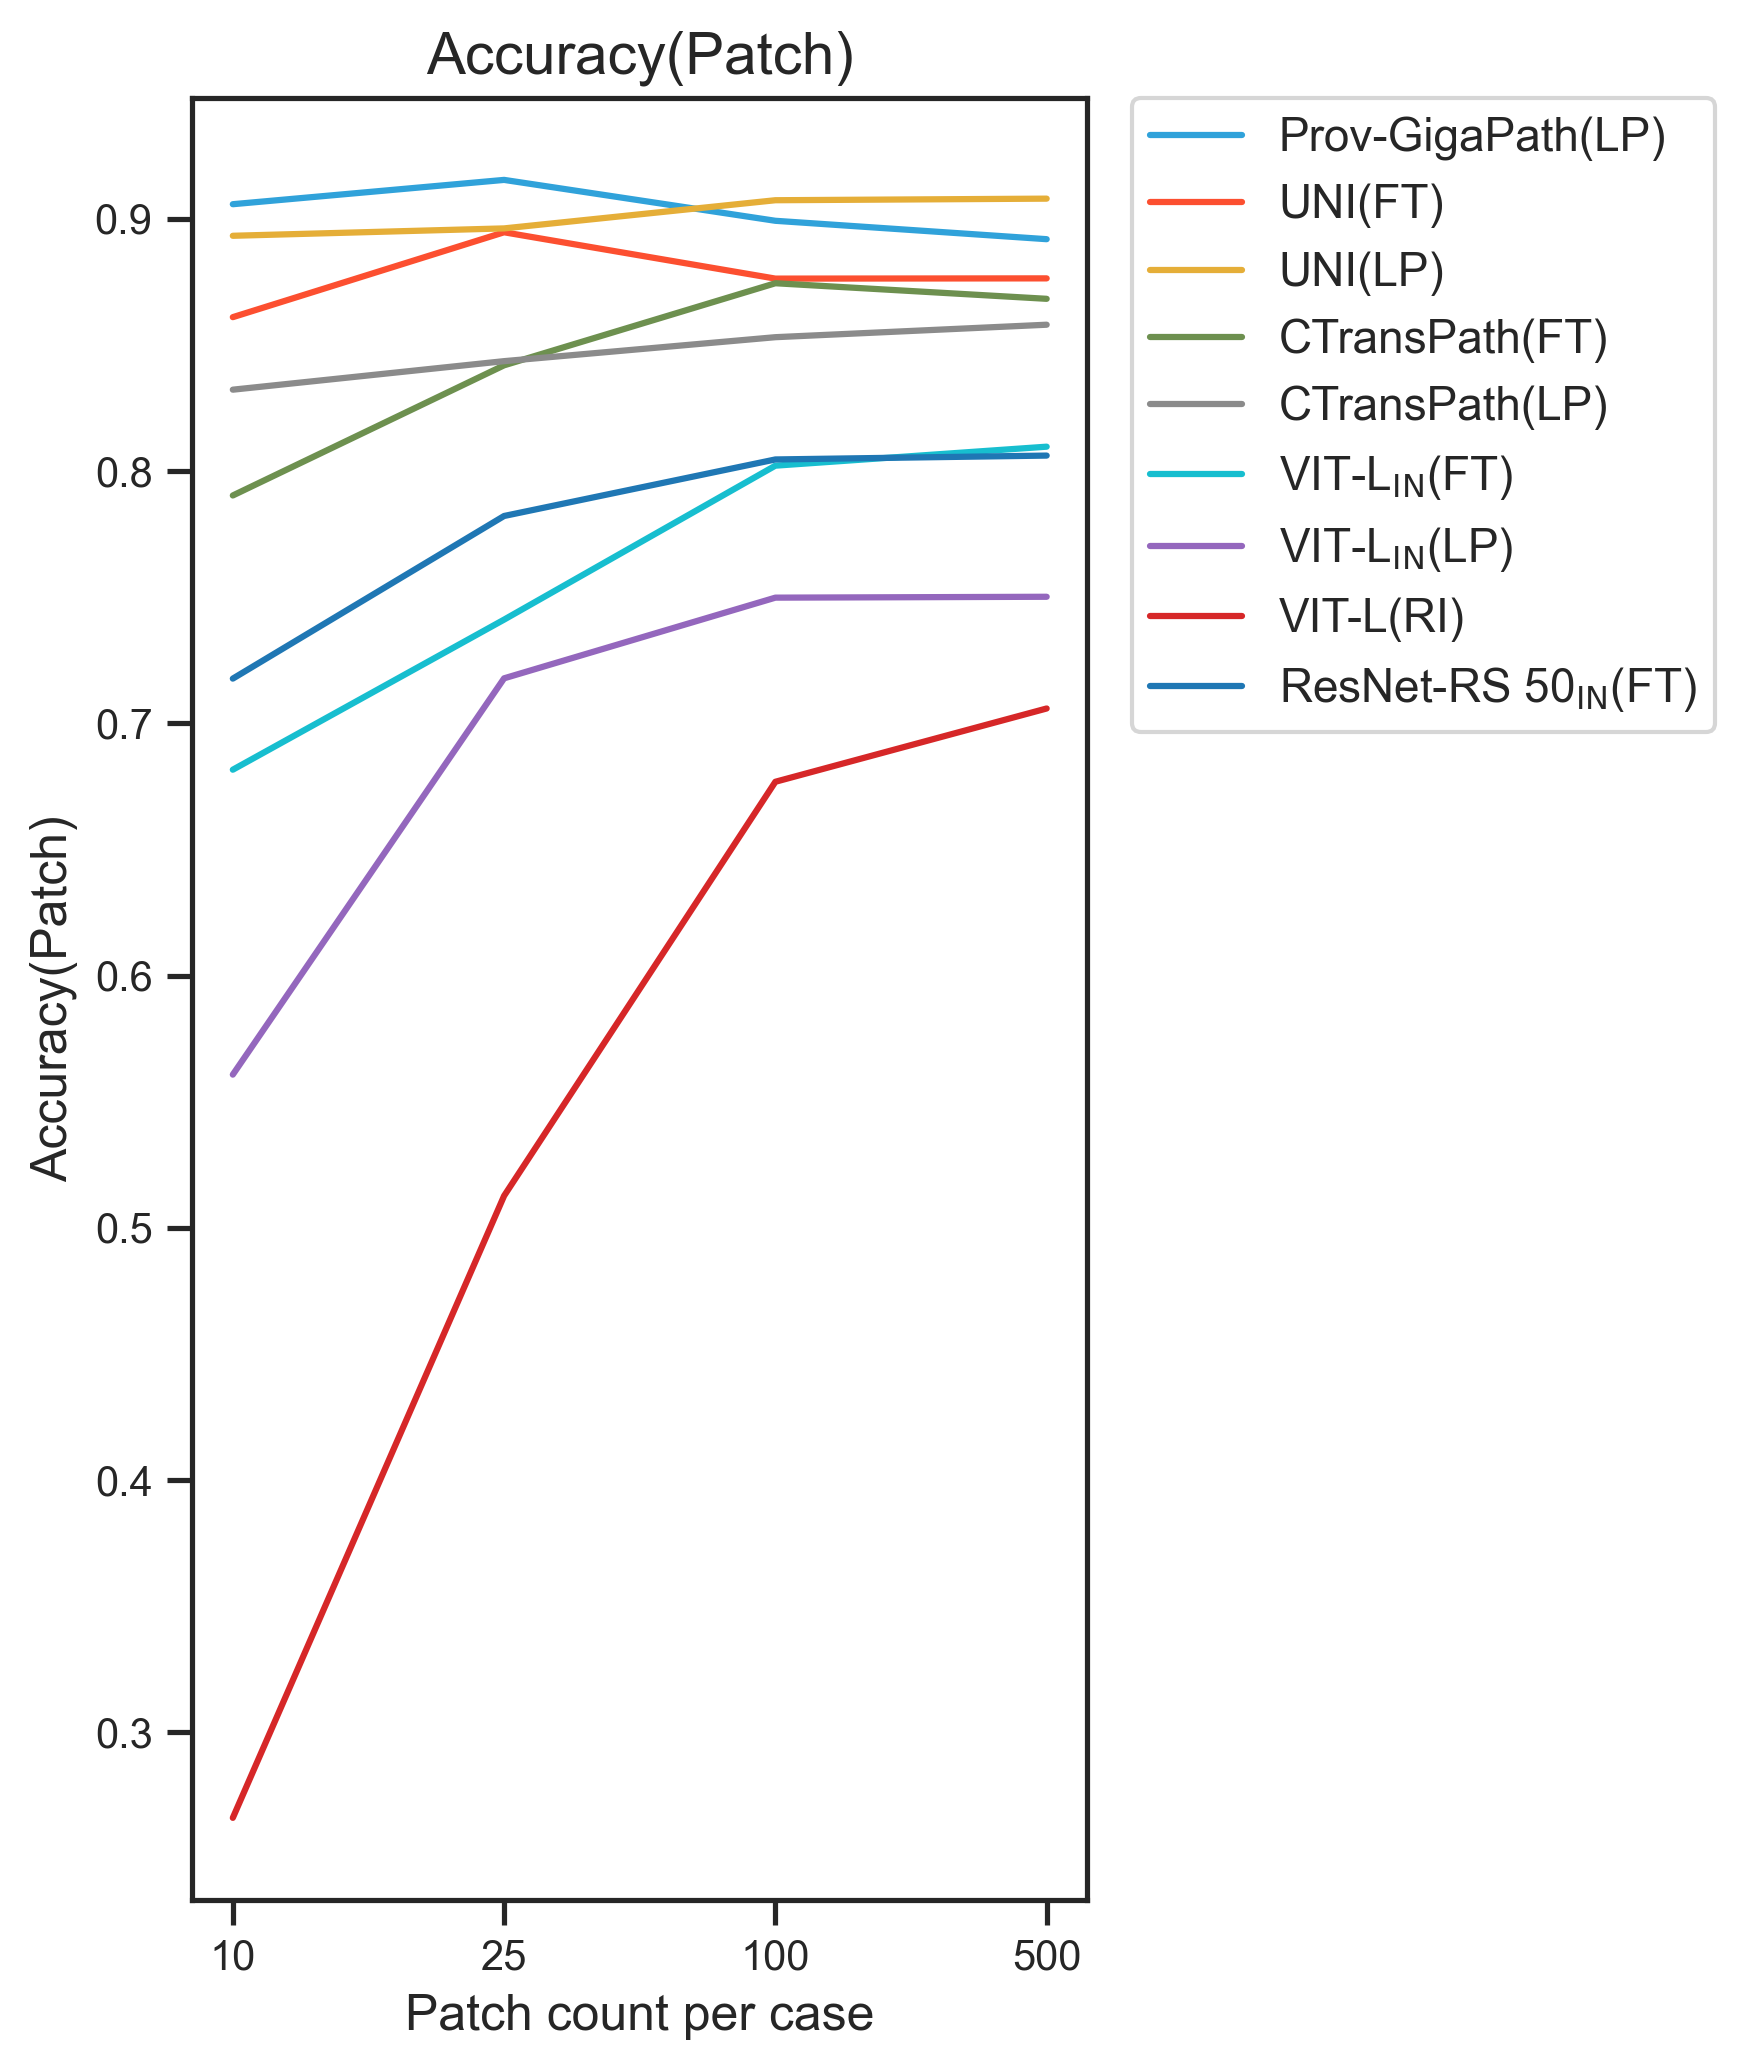

wrote out/figs/lines_ebrains_coarse_acc.png
wrote out/figs/lines_ebrains_coarse_f1.png


In [13]:
draw_lines('ebrains', 'pacc', False, show=True)
draw_lines('ebrains', 'acc', False)
draw_lines('ebrains', 'f1', False)

draw_lines('ebrains', 'pacc', True, show=True)
draw_lines('ebrains', 'acc', True)
draw_lines('ebrains', 'f1', True)